# Хакатон от Альфа-Банка

## Загрузка данных и установвка библиотек

In [1]:
!pip install catboost -q

In [2]:
!pip install shap -q

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV

In [4]:
RANDOM_STATE = 42
VALID_SIZE = 0.25

In [5]:
train_df = pd.read_csv('/content/drive/MyDrive/hackathon_income_train.csv', decimal=',', sep=';')
test_df = pd.read_csv('/content/drive/MyDrive/hackathon_income_test.csv', decimal=',', sep=';')
train_df.shape, test_df.shape

/tmp/ipython-input-1057137046.py:1: DtypeWarning: Columns (66) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('/content/drive/MyDrive/hackathon_income_train.csv', decimal=',', sep=';')
/tmp/ipython-input-1057137046.py:2: DtypeWarning: Columns (65) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv('/content/drive/MyDrive/hackathon_income_test.csv', decimal=',', sep=';')


((76786, 224), (73214, 222))

In [6]:
set(train_df.columns) - set(test_df.columns)

{'target', 'w'}

In [7]:
train_df.head()

id          dt         target  turn_cur_cr_avg_act_v2  salary_6to12m_avg  \
0   2  2024-04-30  109324.476325             1465144.960                NaN   
1   4  2024-02-29   25558.028662              303593.660                NaN   
2   5  2024-02-29   40666.753098              490754.010                NaN   
3   6  2024-04-30   43856.672058              219875.120                NaN   
4   7  2024-04-30  130420.851992             1750241.845                NaN   

  hdb_bki_total_max_limit  dp_ils_paymentssum_avg_12m  \
0                 52800.0               365346.244634   
1                260200.0                         NaN   
2               2000000.0                         NaN   
3                 75000.0                         NaN   
4               1000000.0                         NaN   

  hdb_bki_total_cc_max_limit  incomeValue   gender  ...  \
0                    23213.0      97366.0  Женский  ...   
1                    10000.0      32580.0  Женский  ...   
2                    90000.0      96866.0  Женский  ...   
3                    75000.0      43860.0  Мужской  ...   
4                   240000.0      83815.0  Женский  ...   

   dp_ils_uniq_companies_1y avg_6m_travel  avg_6m_government_services  \
0                       1.0           0.0                        57.0   
1                       NaN           0.0                       707.0   
2                       NaN         422.0                         0.0   
3                       NaN           0.0                         0.0   
4                       NaN           0.0                        84.0   

   hdb_bki_active_cc_max_overdue total_rur_amt_cm_avg_period_days_ago_v2  \
0                            0.0                                   297.0   
1                           67.0                                 30245.0   
2                            0.0                                210322.0   
3                            0.0                                  7187.0   
4                            0.0                                690038.0   

   label_Above_1M_share_r1  transaction_category_supermarket_sum_cnt_d15  \
0                 0.027027                                           9.0   
1                      NaN                                           2.0   
2                 0.000000                                          20.0   
3                 0.000000                                           7.0   
4                 0.000000                                           9.0   

   max_balance_rur_amt_1m_af         w  first_salary_income  
0                        NaN  0.301217                  NaN  
1                        NaN  0.695800                  NaN  
2                        NaN  0.515970                  NaN  
3                        NaN  0.478003                  NaN  
4                        NaN  0.552314                  NaN  

[5 rows x 224 columns]

## Предобработка данных

In [8]:
train_df['id'].duplicated().sum()

np.int64(0)

In [9]:
train_df['dt'].unique()

array(['2024-04-30', '2024-02-29', '2024-03-31', '2024-06-30',
       '2024-01-31', '2024-05-31'], dtype=object)

In [10]:
train_df = train_df.drop(['id', 'dt'], axis=1)

In [11]:
info_missing_value_train = train_df.isna().sum() * 100 / train_df.shape[0]
info_missing_value_train = info_missing_value_train[info_missing_value_train > 0]
info_missing_value_train = info_missing_value_train.to_frame(name='Процент пропусков, %')
info_missing_value_train.shape

(217, 1)

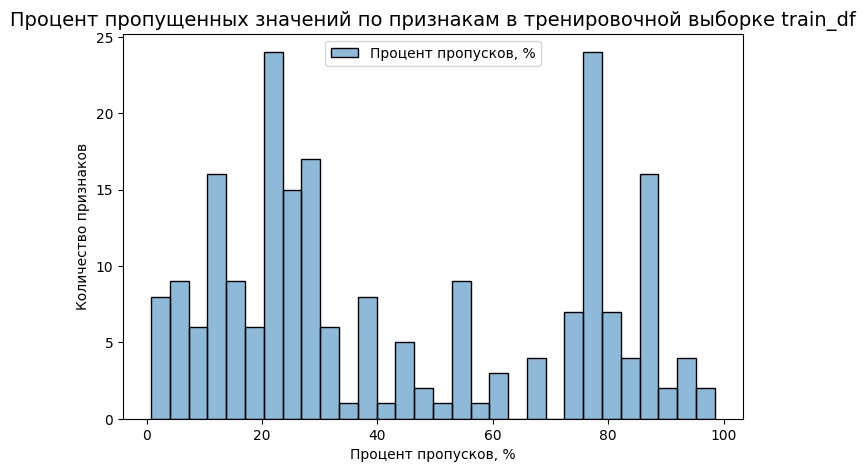

In [12]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.histplot(info_missing_value_train, bins=30, ax=ax)

ax.set_title("Процент пропущенных значений по признакам в тренировочной выборке train_df", fontsize=14)
ax.set_xlabel("Процент пропусков, %", fontsize=10)
ax.set_ylabel("Количество признаков", fontsize=10)
plt.show()

In [13]:
info_missing_value_train_more_70percent = info_missing_value_train[info_missing_value_train['Процент пропусков, %'] >= 70]
info_missing_value_train_more_70percent.shape

(66, 1)

In [14]:
info_missing_value_train_less_70percent = info_missing_value_train[info_missing_value_train['Процент пропусков, %'] < 70]
info_missing_value_train_less_70percent.shape

(151, 1)

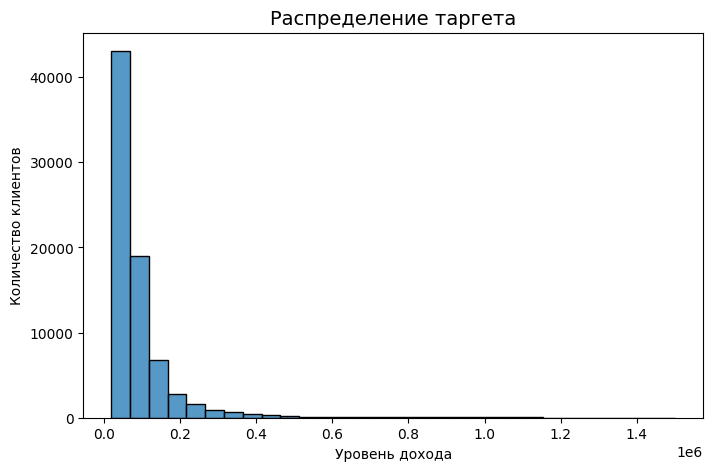

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.histplot(train_df['target'], bins=30, ax=ax)

ax.set_title("Распределение таргета", fontsize=14)
ax.set_xlabel("Уровень дохода", fontsize=10)
ax.set_ylabel("Количество клиентов", fontsize=10)
plt.show()

In [16]:
train_df['target'].describe()

count    7.678600e+04
mean     9.264824e+04
std      1.124090e+05
min      2.000000e+04
25%      3.970997e+04
50%      6.275413e+04
75%      1.002017e+05
max      1.500000e+06
Name: target, dtype: float64

In [17]:
train_df['target'].isna().sum()

np.int64(0)

In [18]:
train_df.dtypes.unique()

array([dtype('float64'), dtype('O')], dtype=object)

## Исследуем важность (влияние) признаков

In [19]:
X = train_df.drop(columns=['target', 'w'])
y = train_df['target']
w = train_df['w']

In [20]:
cat_cols = X.select_dtypes(include=['object']).columns
for col in cat_cols:
    X[col] = X[col].astype(str).fillna('missing')

cat_idx = [X.columns.get_loc(c) for c in cat_cols]

print('Числовых признаков:', X.select_dtypes(include='number').shape[1])
print('Категориальных признаков:', len(cat_cols))

Числовых признаков: 180
Категориальных признаков: 40


In [21]:
model = CatBoostRegressor(
    loss_function='MAE',
    depth=6,
    learning_rate=0.05,
    iterations=800,
    random_state=42,
    verbose=100
)

model.fit(X, y, cat_features=cat_idx, sample_weight=w)

0:	learn: 130266.5383219	total: 898ms	remaining: 11m 57s
100:	learn: 80971.9912132	total: 1m 20s	remaining: 9m 19s
200:	learn: 74706.9268875	total: 2m 47s	remaining: 8m 18s
300:	learn: 71487.1672741	total: 4m 7s	remaining: 6m 50s
400:	learn: 69347.9078881	total: 5m 30s	remaining: 5m 29s
500:	learn: 67916.7623443	total: 6m 55s	remaining: 4m 8s
600:	learn: 66841.3172236	total: 8m 15s	remaining: 2m 44s
700:	learn: 65924.4079232	total: 9m 47s	remaining: 1m 22s
799:	learn: 65214.7112143	total: 11m 9s	remaining: 0us


In [22]:
explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
shap_values = explainer(X)

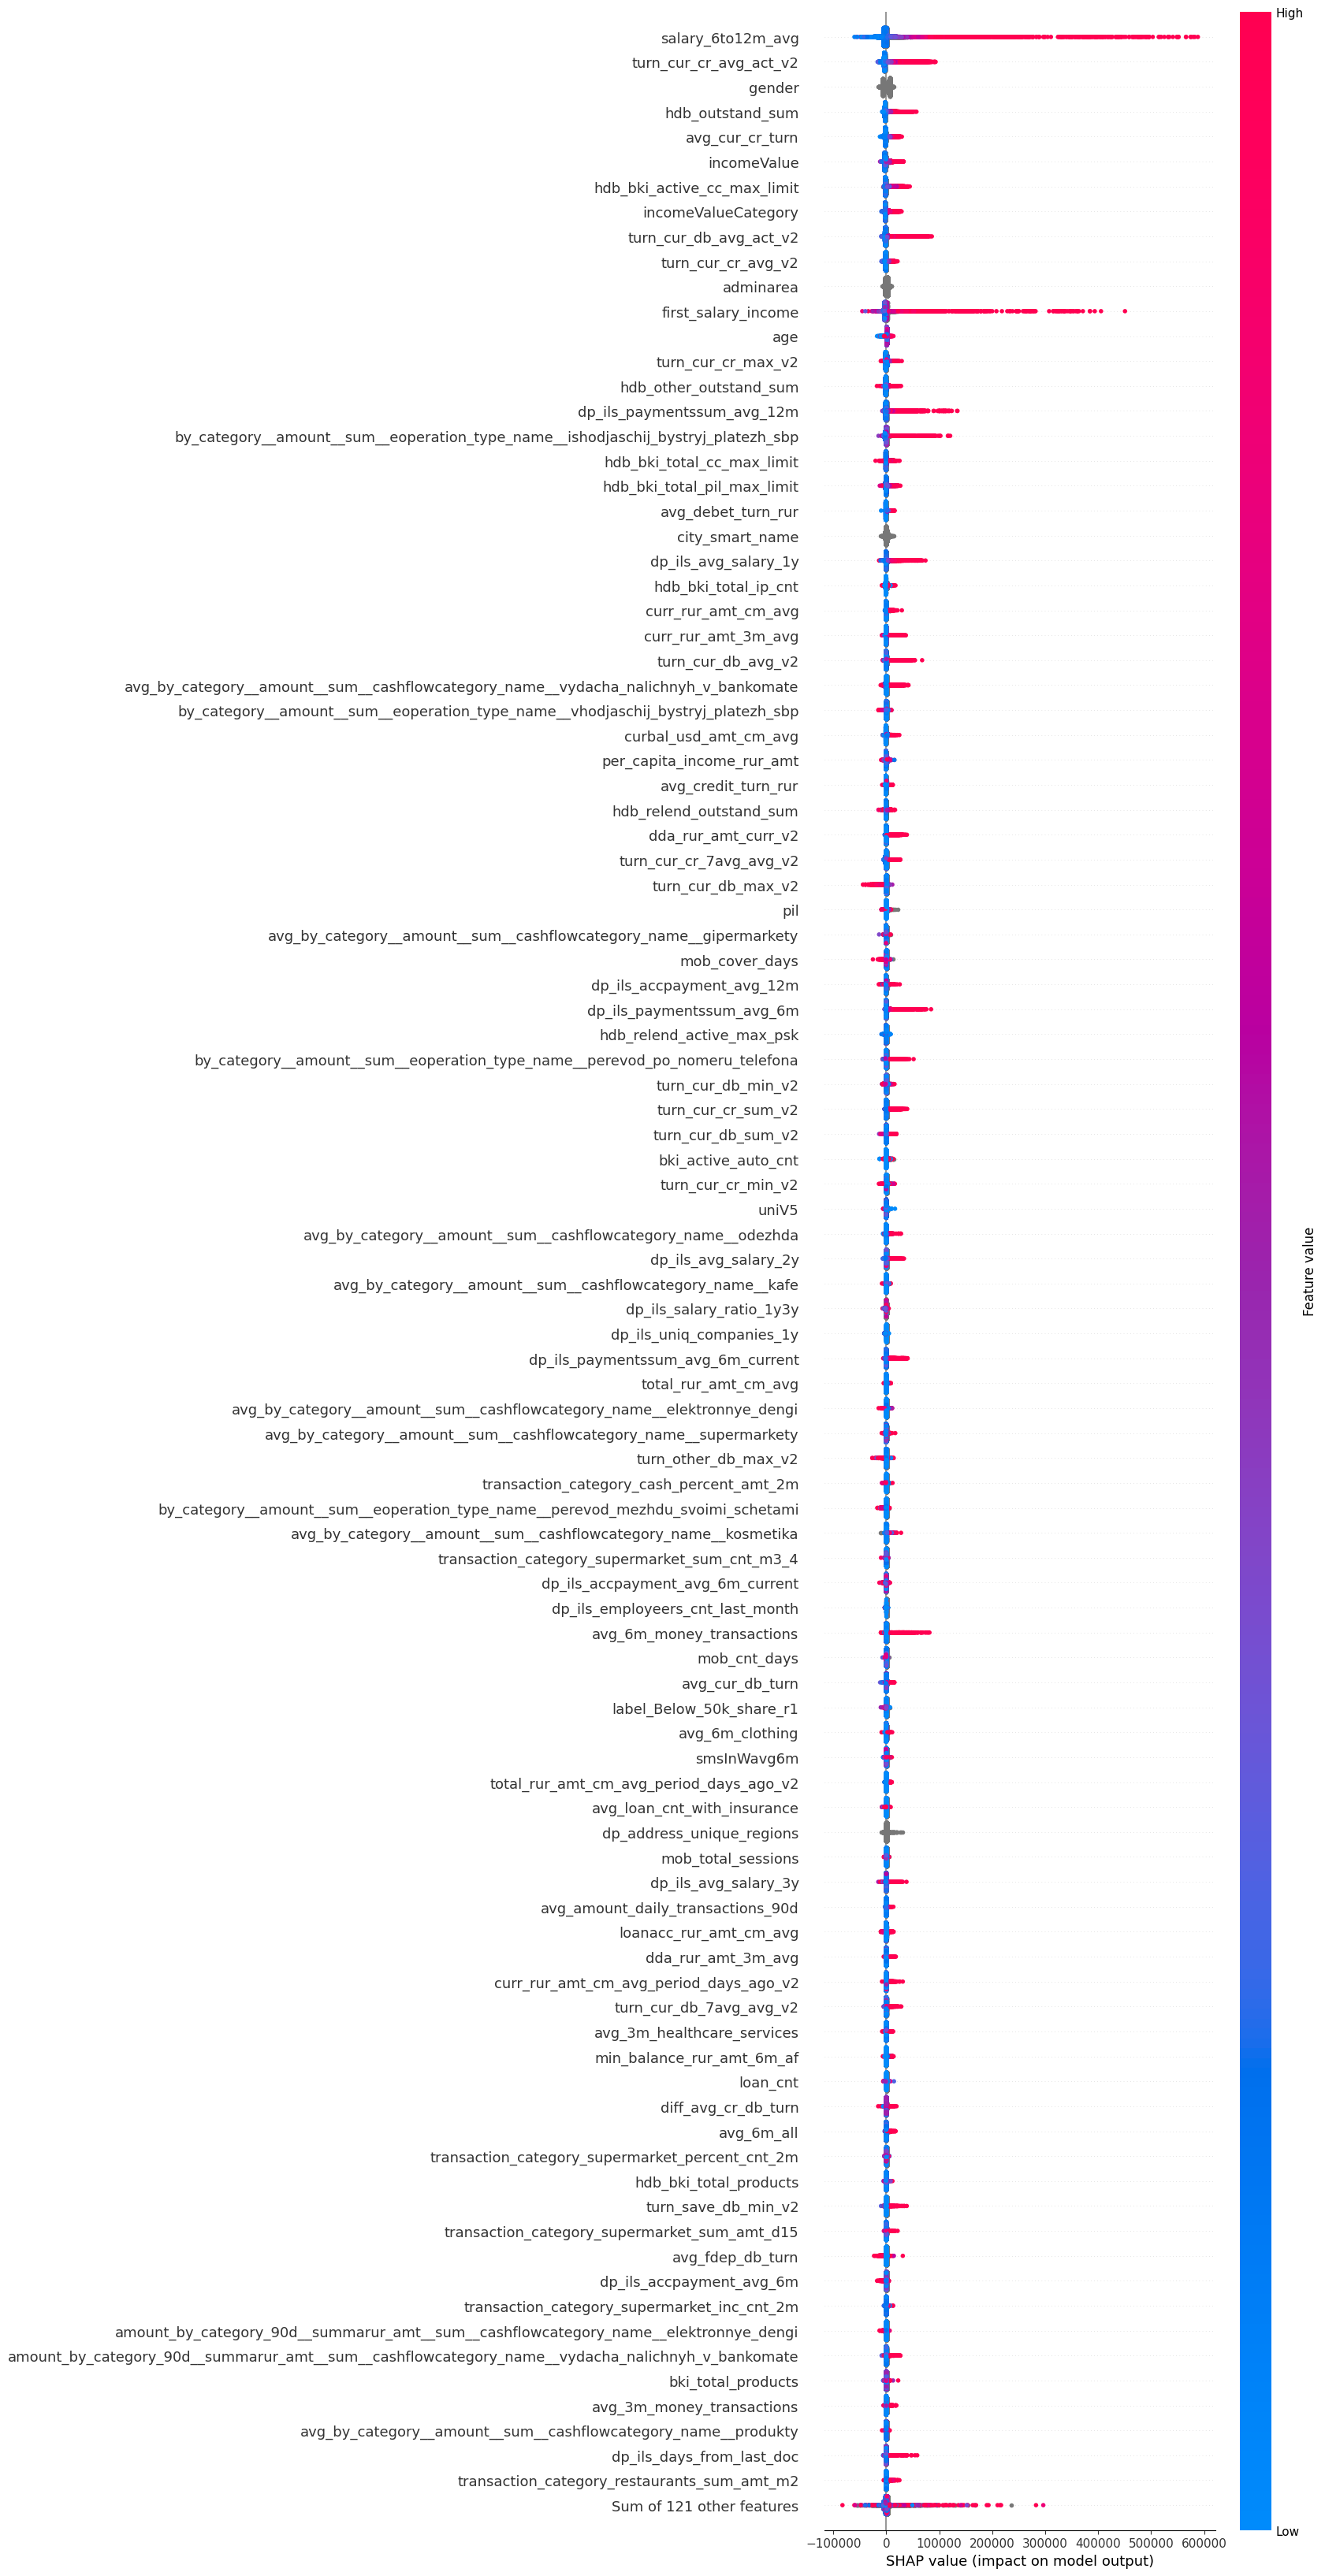

In [23]:
plt.figure(figsize=(25, 40))
shap.plots.beeswarm(shap_values, max_display=100, show=False)
plt.show()

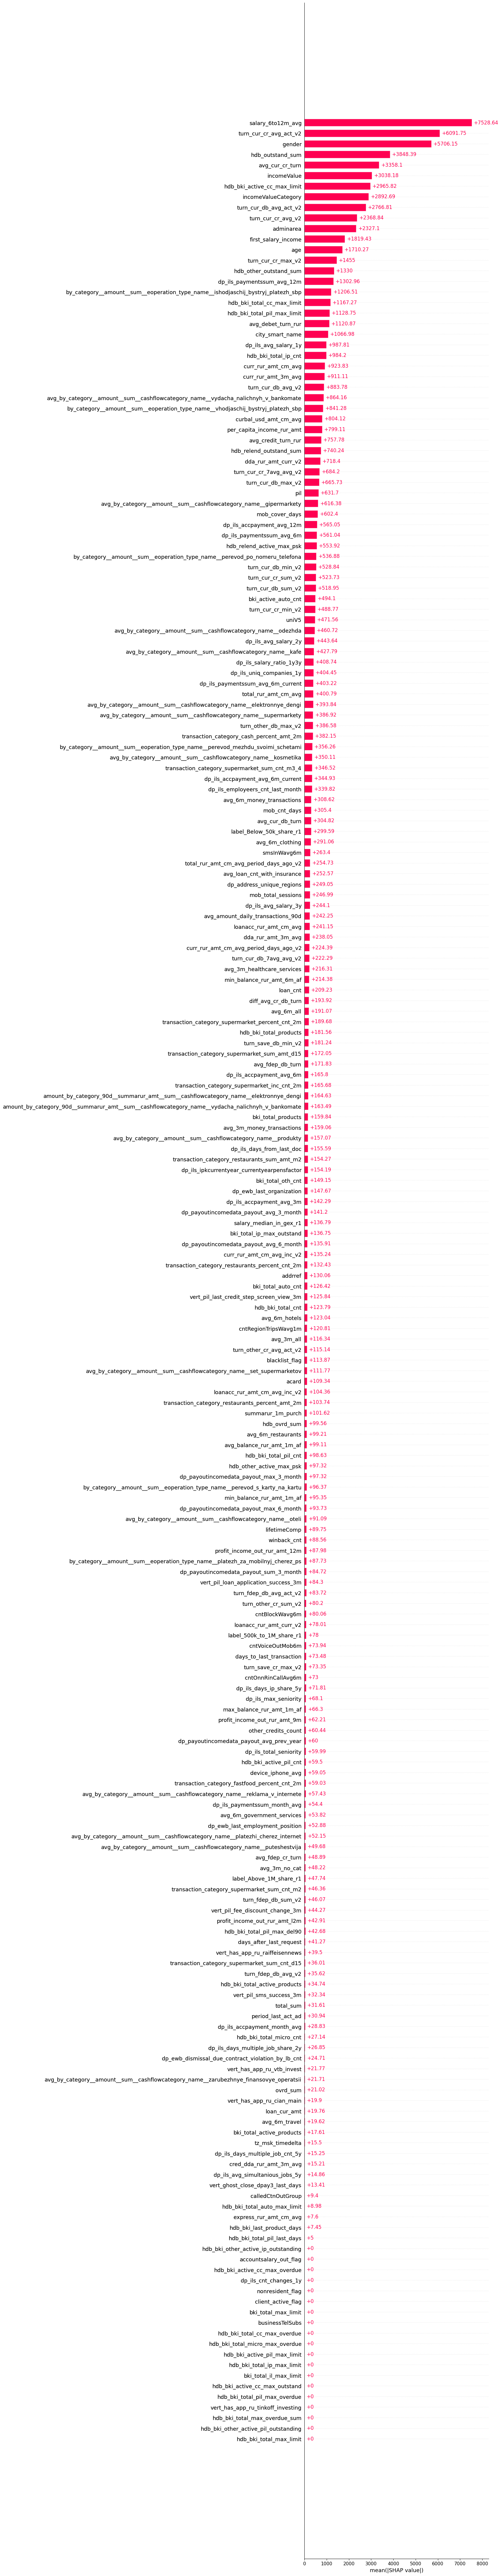

In [24]:
plt.figure(figsize=(25, 40))
shap.plots.bar(shap_values, max_display=X.shape[1], show=False)
plt.show()

## Клиентские категории

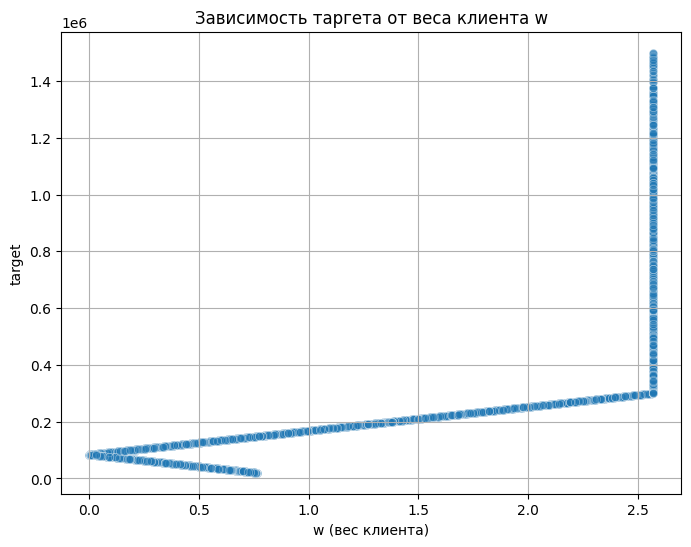

In [25]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=train_df, x='w', y='target', alpha=0.4)

plt.title("Зависимость таргета от веса клиента w")
plt.xlabel("w (вес клиента)")
plt.ylabel("target")
plt.grid(True)
plt.show()

In [26]:
train_df['w'].max()

2.5707025302320754

In [27]:
train_df.loc[train_df['w'] == train_df['w'].max(), 'target'].min()

300000.0

По графику корреляции между важностью клиента и доходом можно разбить клиентов на три категории:
1) Премиальный сегмент

Вес == 2.5707025302320754

Доход более 300000

2) Приоритетный сегмент

Вес от 0 до 2.5707025302320754

Доход от 100000 до 300000

3) Стандартный сегмент

Вес от 0 до 0.75 и уменьшается с увеличением дохода

Доход от 0 до 100000
Можно предположить, что информация о нулевых доходах может быть связана с отсутствием информации о доходах клиента, он не пользуется услугами банка, банк пытается клиента завлечь, а затем при появлении информации о невысоком доходе интрес банка к клиенту падает.

Будем отбирать соответсвующие признаки в порядке значимости клиента для банка.

### Премиальный сегмент

In [28]:
mask_premium = (train_df['w'] == train_df['w'].max())

X_premium = X[mask_premium].copy()
y_premium = train_df.loc[mask_premium, 'target']

X_premium.shape, y_premium.shape

((2896, 220), (2896,))

In [29]:
shap_premium_values = explainer(X_premium)
shap_premium_values.values.shape

(2896, 220)

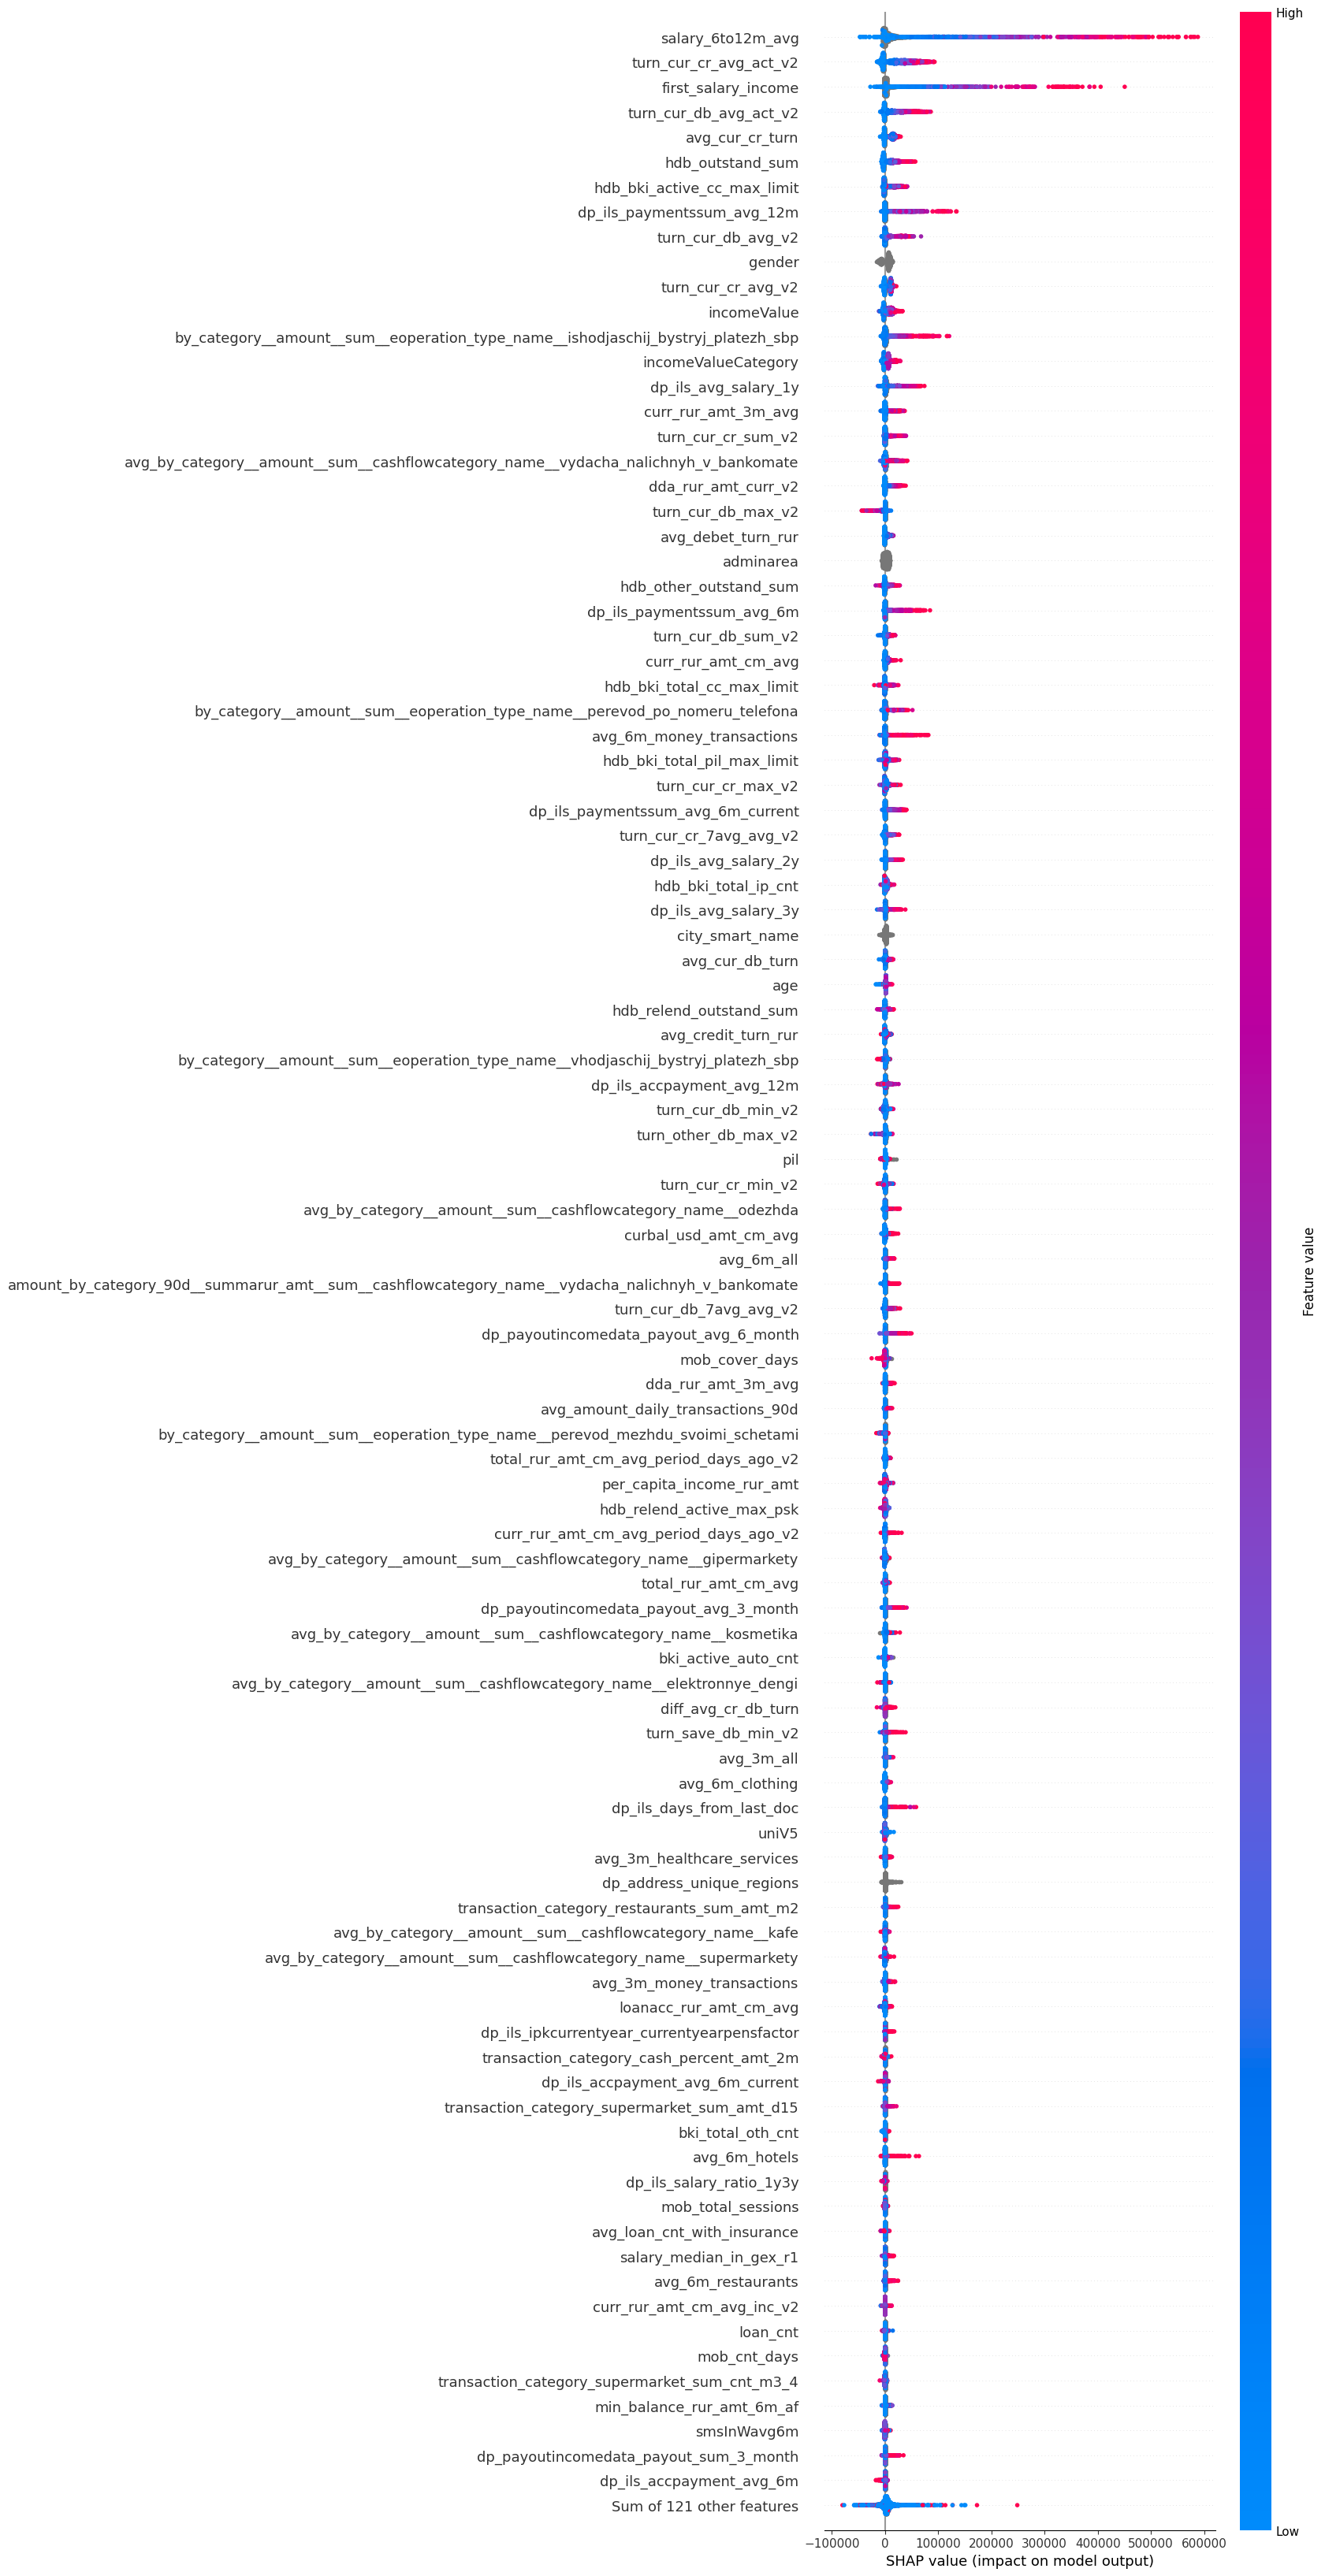

In [30]:
plt.figure(figsize=(25, 40))
shap.plots.beeswarm(shap_premium_values, max_display=100, show=False)
plt.show()

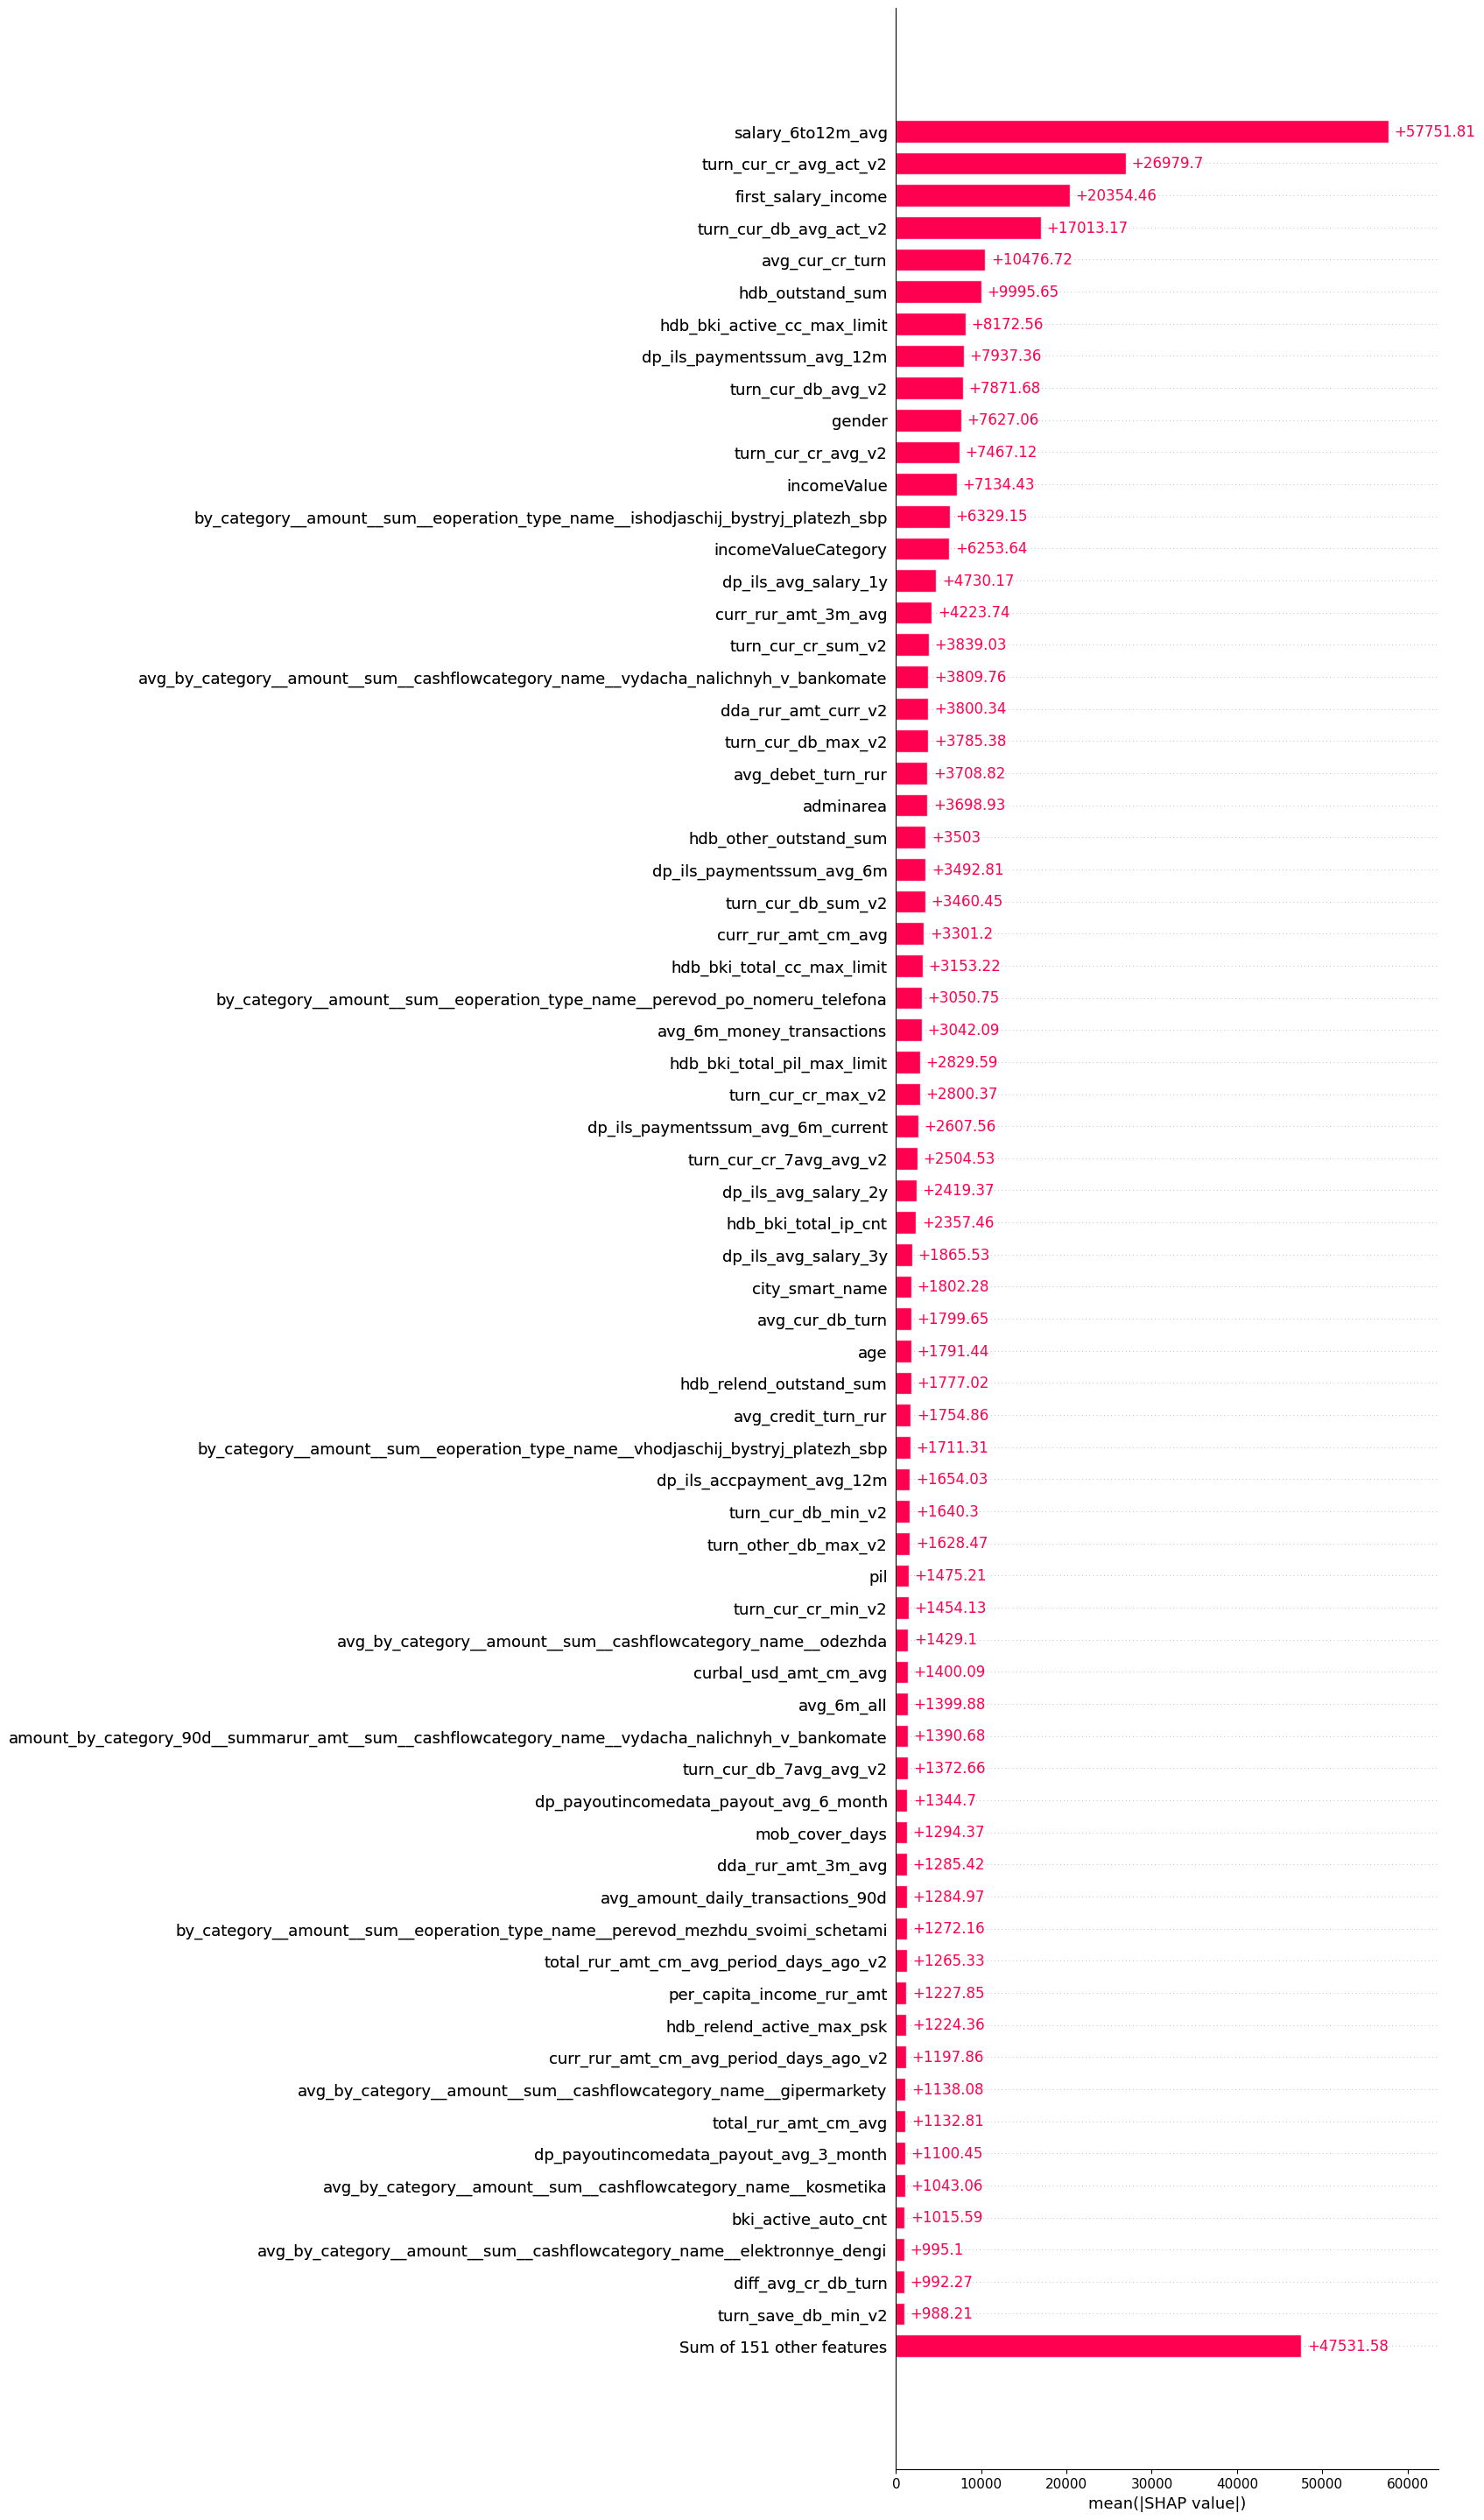

In [31]:
plt.figure(figsize=(16, 40))
shap.plots.bar(shap_premium_values, max_display=70, show=False)
plt.show()

In [32]:
mean_abs_shap_premium = np.abs(shap_premium_values.values).mean(axis=0)

feature_importance_premium = pd.Series(mean_abs_shap_premium, index=shap_premium_values.feature_names, name="Средний |SHAP|").sort_values(ascending=False)

top_features_premium = feature_importance_premium.index[:70].tolist()
top_features_premium

['salary_6to12m_avg',
 'turn_cur_cr_avg_act_v2',
 'first_salary_income',
 'turn_cur_db_avg_act_v2',
 'avg_cur_cr_turn',
 'hdb_outstand_sum',
 'hdb_bki_active_cc_max_limit',
 'dp_ils_paymentssum_avg_12m',
 'turn_cur_db_avg_v2',
 'gender',
 'turn_cur_cr_avg_v2',
 'incomeValue',
 'by_category__amount__sum__eoperation_type_name__ishodjaschij_bystryj_platezh_sbp',
 'incomeValueCategory',
 'dp_ils_avg_salary_1y',
 'curr_rur_amt_3m_avg',
 'turn_cur_cr_sum_v2',
 'avg_by_category__amount__sum__cashflowcategory_name__vydacha_nalichnyh_v_bankomate',
 'dda_rur_amt_curr_v2',
 'turn_cur_db_max_v2',
 'avg_debet_turn_rur',
 'adminarea',
 'hdb_other_outstand_sum',
 'dp_ils_paymentssum_avg_6m',
 'turn_cur_db_sum_v2',
 'curr_rur_amt_cm_avg',
 'hdb_bki_total_cc_max_limit',
 'by_category__amount__sum__eoperation_type_name__perevod_po_nomeru_telefona',
 'avg_6m_money_transactions',
 'hdb_bki_total_pil_max_limit',
 'turn_cur_cr_max_v2',
 'dp_ils_paymentssum_avg_6m_current',
 'turn_cur_cr_7avg_avg_v2',
 'dp_i

### Приоритетный сегмент

In [33]:
mask_priority = ((train_df['w'] < train_df['w'].max()) & (train_df['target'] < 300000) & (train_df['target'] >= 100000))

X_priority = X[mask_priority].copy()
y_priority = train_df.loc[mask_priority, 'target']

X_priority.shape, y_priority.shape

((16539, 220), (16539,))

In [34]:
shap_priority_values = explainer(X_priority)
shap_priority_values.values.shape

(16539, 220)

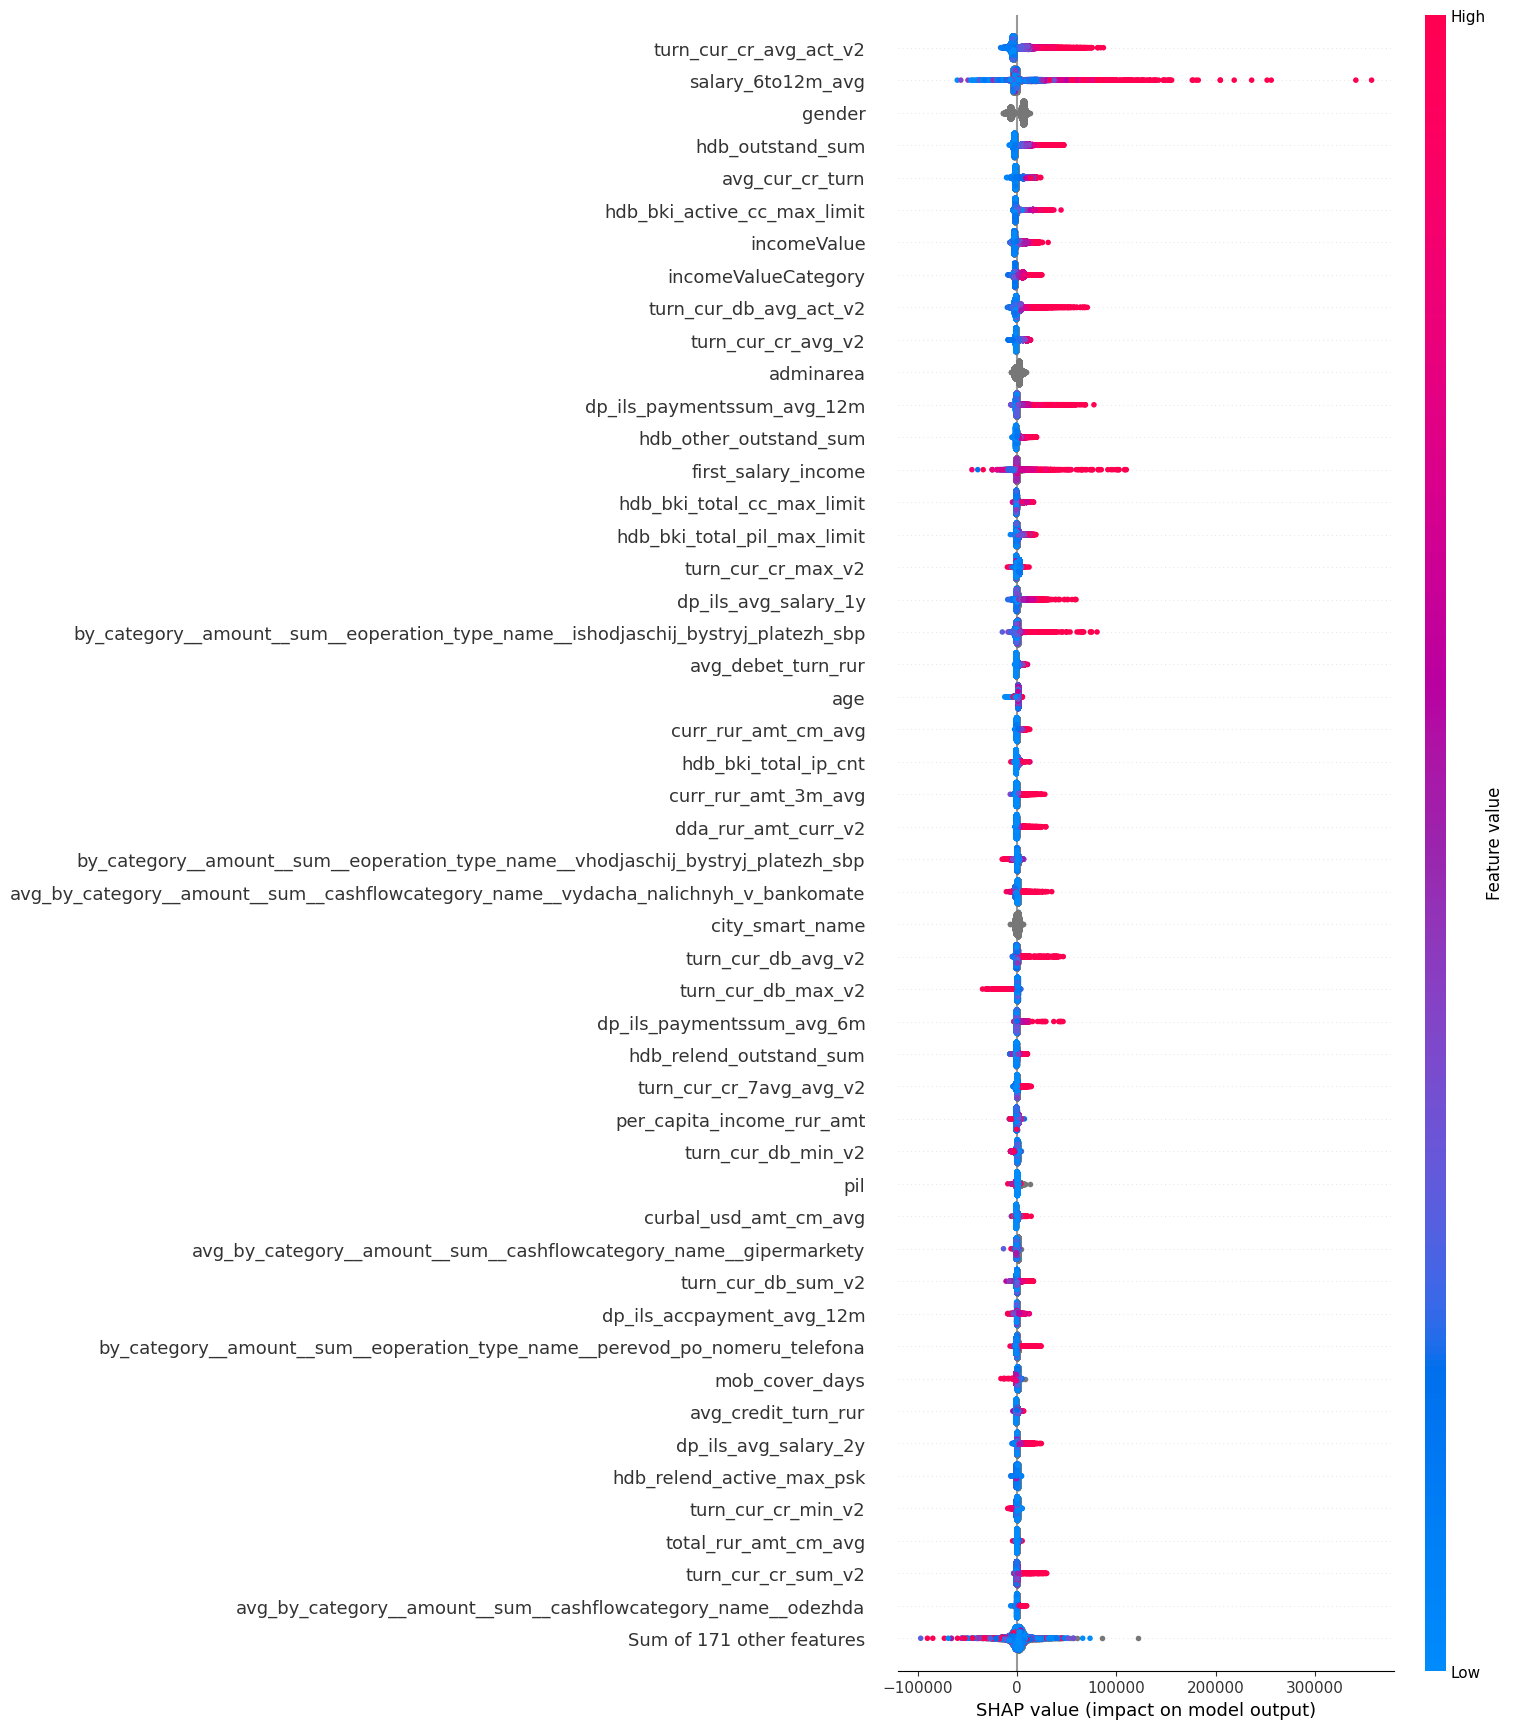

In [35]:
plt.figure(figsize=(25, 40))
shap.plots.beeswarm(shap_priority_values, max_display=50, show=False)
plt.show()

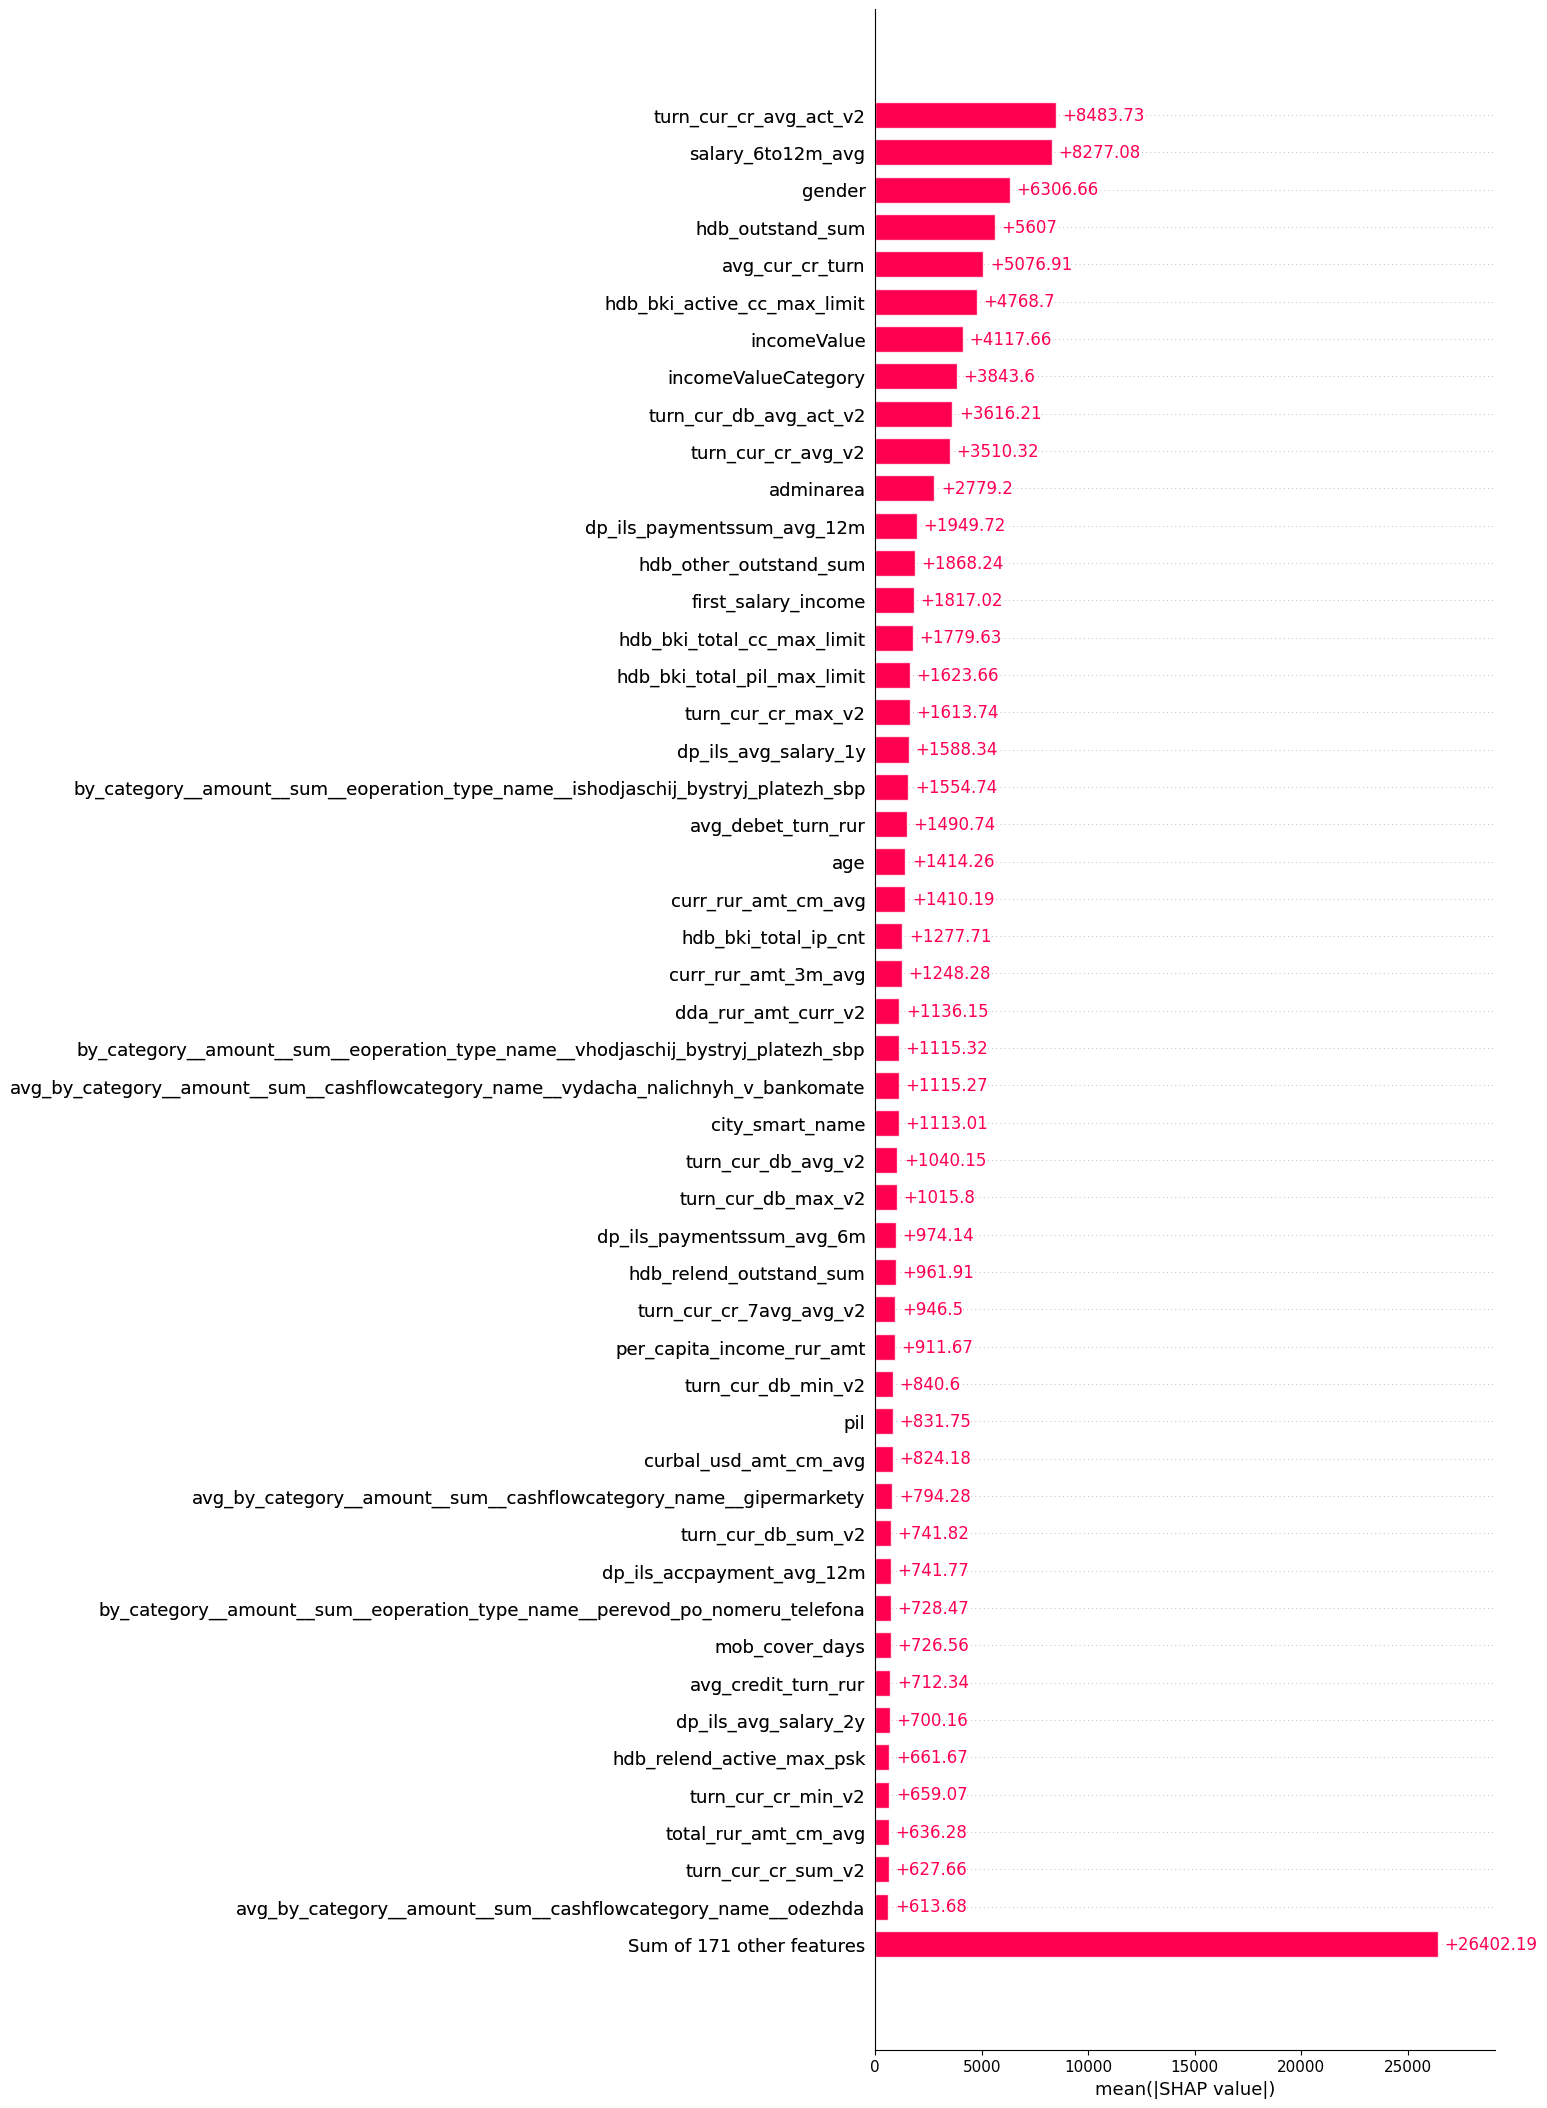

In [36]:
plt.figure(figsize=(24, 40))
shap.plots.bar(shap_priority_values, max_display=50, show=False)
plt.show()

In [37]:
mean_abs_shap_priority = np.abs(shap_priority_values.values).mean(axis=0)

feature_importance_priority = pd.Series(mean_abs_shap_priority, index=shap_priority_values.feature_names, name="Средний |SHAP|").sort_values(ascending=False)

# После 12 признаков происходит резкий спад значимости
top12_features_priority = feature_importance_priority.index[:12].tolist()
top12_features_priority

['turn_cur_cr_avg_act_v2',
 'salary_6to12m_avg',
 'gender',
 'hdb_outstand_sum',
 'avg_cur_cr_turn',
 'hdb_bki_active_cc_max_limit',
 'incomeValue',
 'incomeValueCategory',
 'turn_cur_db_avg_act_v2',
 'turn_cur_cr_avg_v2',
 'adminarea',
 'dp_ils_paymentssum_avg_12m']

In [38]:
set(top12_features_priority) - set(top_features_premium)

set()

In [39]:
top12_features_priority = top_features_premium + (list(set(top12_features_priority) - set(top_features_premium)))
top12_features_priority

['salary_6to12m_avg',
 'turn_cur_cr_avg_act_v2',
 'first_salary_income',
 'turn_cur_db_avg_act_v2',
 'avg_cur_cr_turn',
 'hdb_outstand_sum',
 'hdb_bki_active_cc_max_limit',
 'dp_ils_paymentssum_avg_12m',
 'turn_cur_db_avg_v2',
 'gender',
 'turn_cur_cr_avg_v2',
 'incomeValue',
 'by_category__amount__sum__eoperation_type_name__ishodjaschij_bystryj_platezh_sbp',
 'incomeValueCategory',
 'dp_ils_avg_salary_1y',
 'curr_rur_amt_3m_avg',
 'turn_cur_cr_sum_v2',
 'avg_by_category__amount__sum__cashflowcategory_name__vydacha_nalichnyh_v_bankomate',
 'dda_rur_amt_curr_v2',
 'turn_cur_db_max_v2',
 'avg_debet_turn_rur',
 'adminarea',
 'hdb_other_outstand_sum',
 'dp_ils_paymentssum_avg_6m',
 'turn_cur_db_sum_v2',
 'curr_rur_amt_cm_avg',
 'hdb_bki_total_cc_max_limit',
 'by_category__amount__sum__eoperation_type_name__perevod_po_nomeru_telefona',
 'avg_6m_money_transactions',
 'hdb_bki_total_pil_max_limit',
 'turn_cur_cr_max_v2',
 'dp_ils_paymentssum_avg_6m_current',
 'turn_cur_cr_7avg_avg_v2',
 'dp_i

In [40]:
len(top12_features_priority)

70

### Стандартный сегмент

In [41]:
mask_standard = ((train_df['w'] < 0.75) & (train_df['target'] < 100000))

X_standard = X[mask_standard].copy()
y_standard = train_df.loc[mask_standard, 'target']

X_standard.shape, y_standard.shape

((55728, 220), (55728,))

In [42]:
X_premium.shape[0] + X_priority.shape[0] + X_standard.shape[0]

75163

In [43]:
train_df.shape[0]

76786

In [44]:
shap_standard_values = explainer(X_standard)
shap_standard_values.values.shape

(55728, 220)

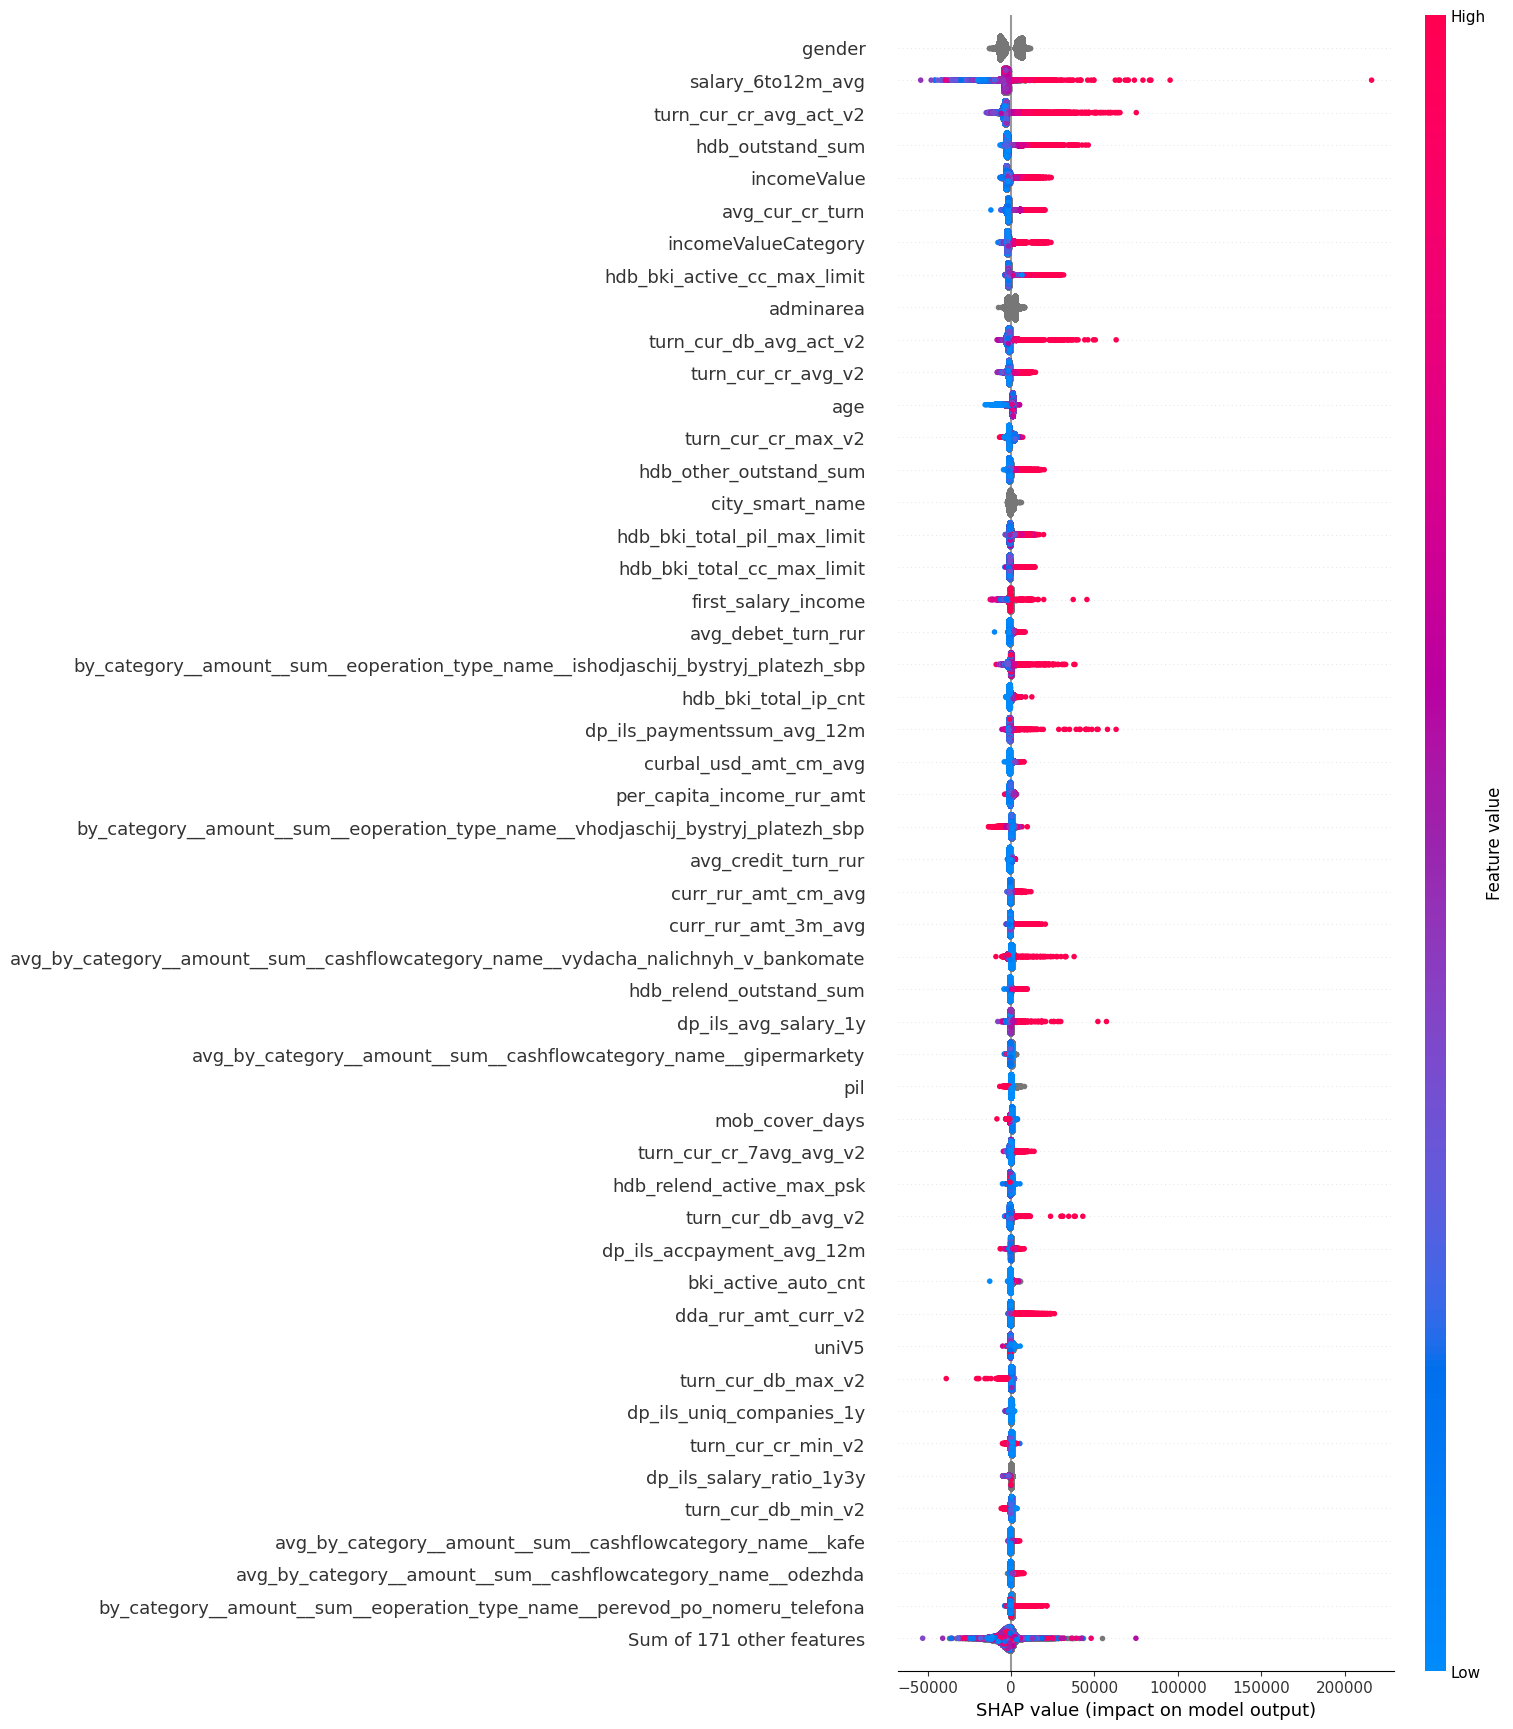

In [45]:
plt.figure(figsize=(25, 40))
shap.plots.beeswarm(shap_standard_values, max_display=50, show=False)
plt.show()

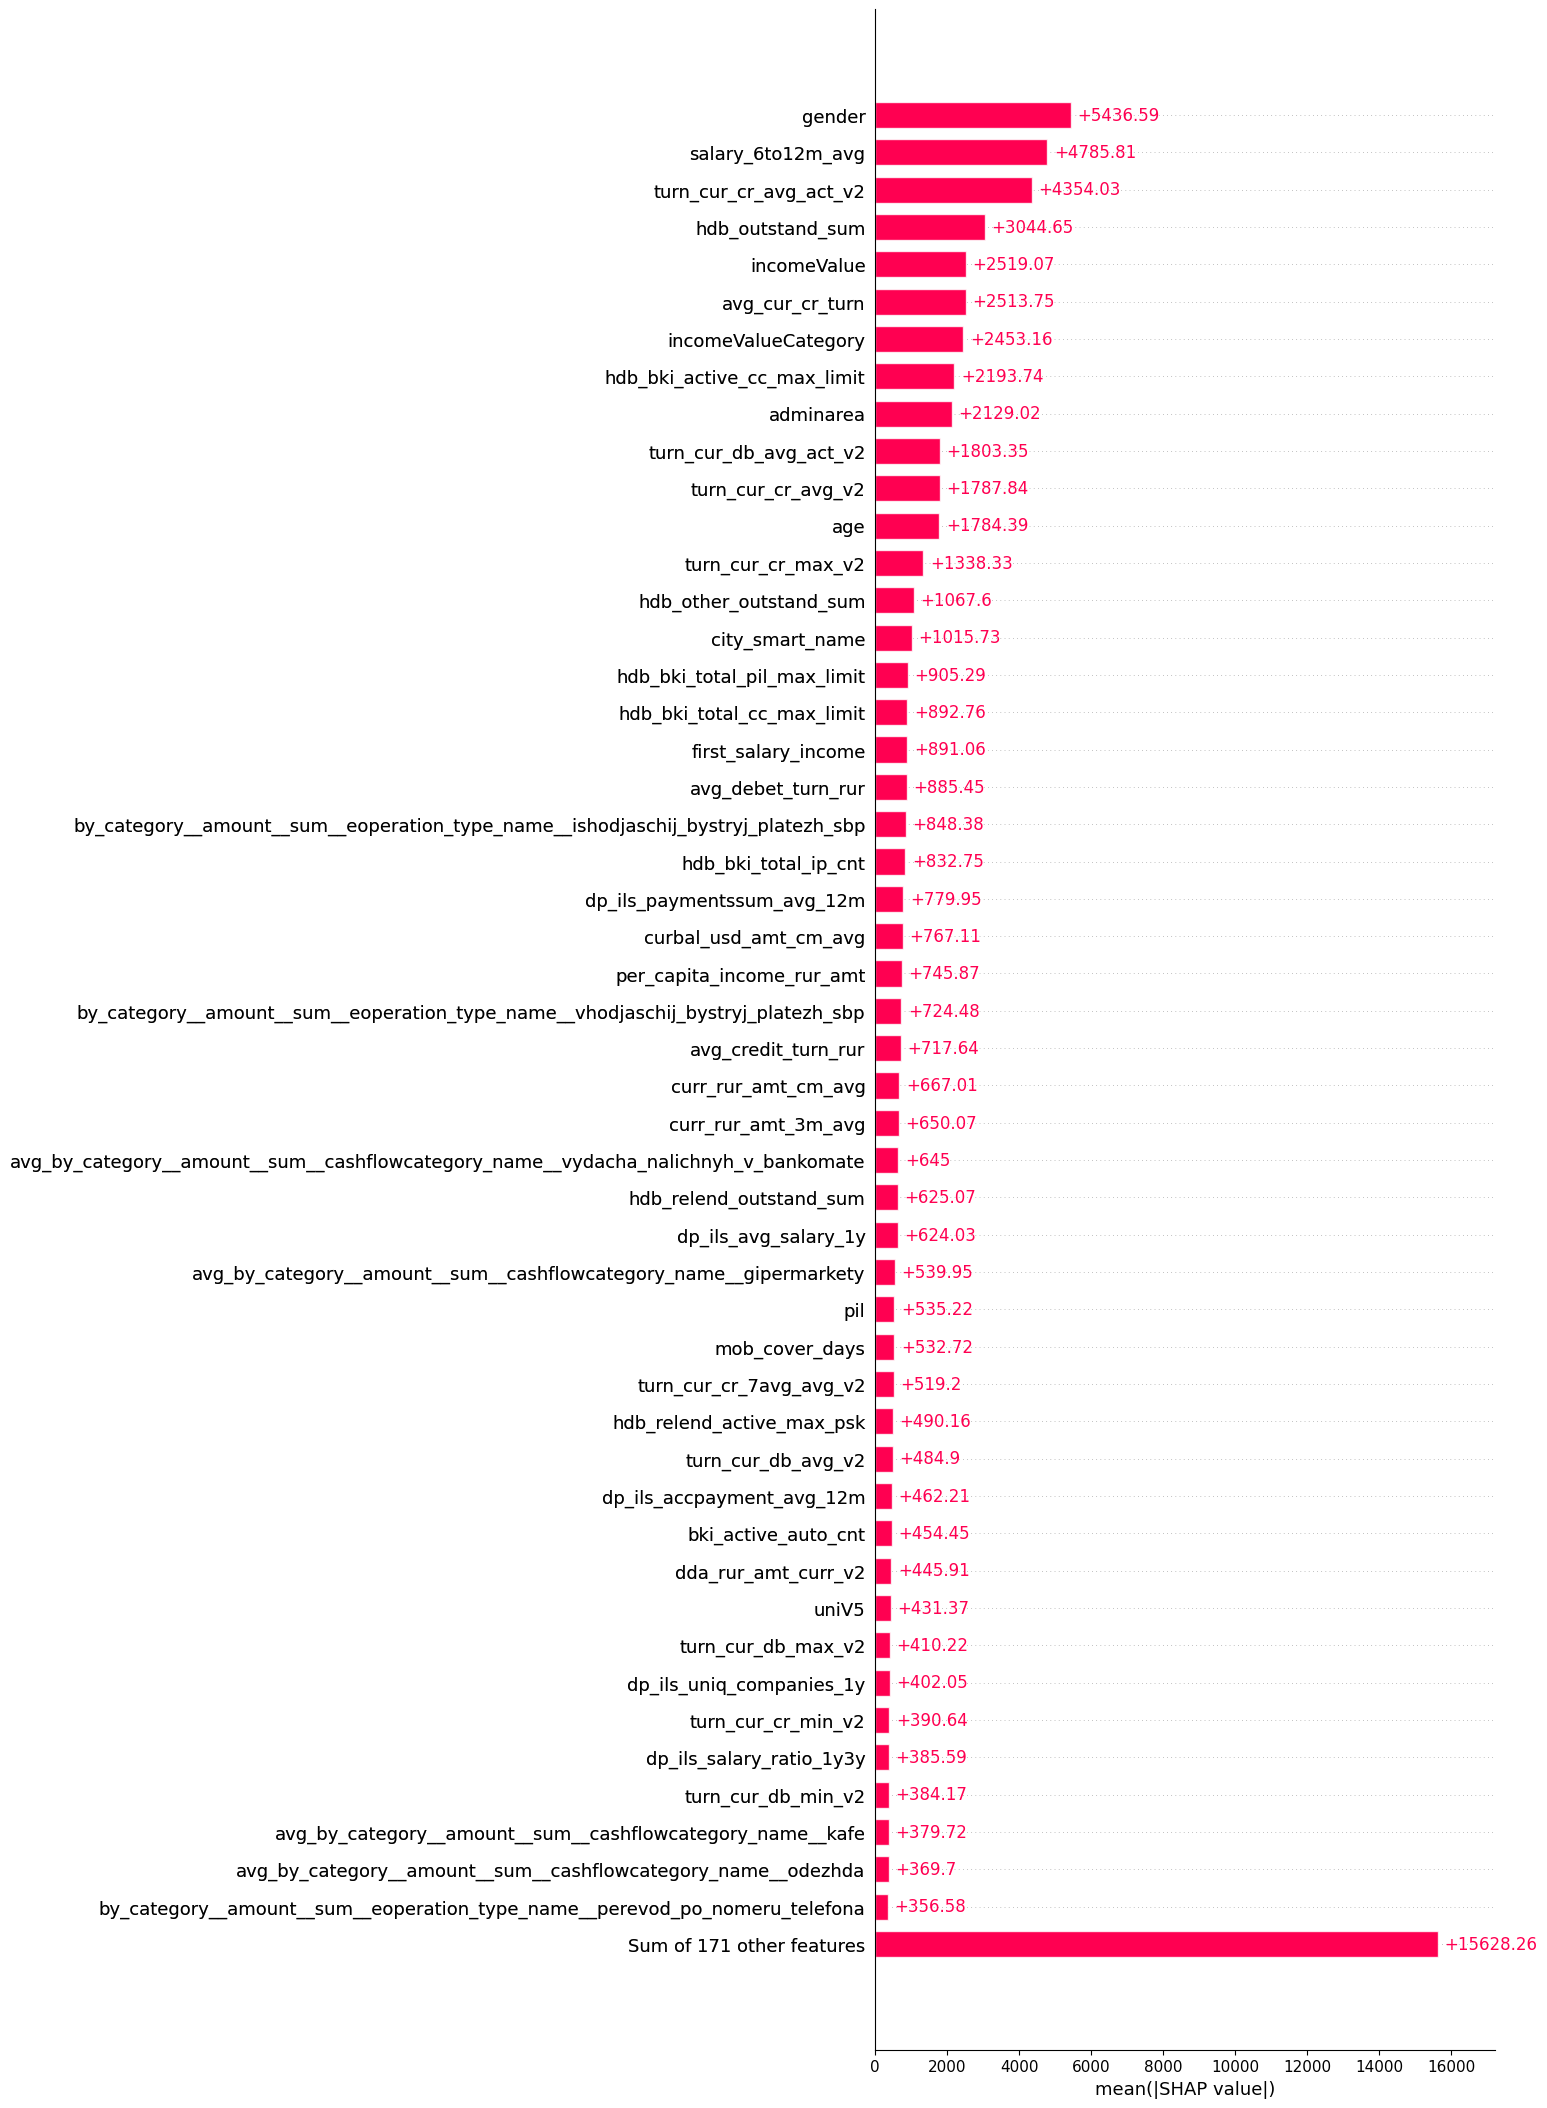

In [46]:
plt.figure(figsize=(24, 40))
shap.plots.bar(shap_standard_values, max_display=50, show=False)
plt.show()

In [47]:
mean_abs_shap_standard = np.abs(shap_standard_values.values).mean(axis=0)

feature_importance_standard = pd.Series(mean_abs_shap_standard, index=shap_standard_values.feature_names, name="Средний |SHAP|").sort_values(ascending=False)

# После 12 признаков происходит резкий спад значимости
top12_features_standard = feature_importance_standard.index[:12].tolist()
top12_features_standard

['gender',
 'salary_6to12m_avg',
 'turn_cur_cr_avg_act_v2',
 'hdb_outstand_sum',
 'incomeValue',
 'avg_cur_cr_turn',
 'incomeValueCategory',
 'hdb_bki_active_cc_max_limit',
 'adminarea',
 'turn_cur_db_avg_act_v2',
 'turn_cur_cr_avg_v2',
 'age']

In [48]:
set(top12_features_standard) - set(top12_features_priority)

set()

In [49]:
len(top12_features_priority)

70

In [50]:
top12_features_standard = top12_features_priority + (list(set(top12_features_standard) - set(top12_features_priority)))
top12_features_standard

['salary_6to12m_avg',
 'turn_cur_cr_avg_act_v2',
 'first_salary_income',
 'turn_cur_db_avg_act_v2',
 'avg_cur_cr_turn',
 'hdb_outstand_sum',
 'hdb_bki_active_cc_max_limit',
 'dp_ils_paymentssum_avg_12m',
 'turn_cur_db_avg_v2',
 'gender',
 'turn_cur_cr_avg_v2',
 'incomeValue',
 'by_category__amount__sum__eoperation_type_name__ishodjaschij_bystryj_platezh_sbp',
 'incomeValueCategory',
 'dp_ils_avg_salary_1y',
 'curr_rur_amt_3m_avg',
 'turn_cur_cr_sum_v2',
 'avg_by_category__amount__sum__cashflowcategory_name__vydacha_nalichnyh_v_bankomate',
 'dda_rur_amt_curr_v2',
 'turn_cur_db_max_v2',
 'avg_debet_turn_rur',
 'adminarea',
 'hdb_other_outstand_sum',
 'dp_ils_paymentssum_avg_6m',
 'turn_cur_db_sum_v2',
 'curr_rur_amt_cm_avg',
 'hdb_bki_total_cc_max_limit',
 'by_category__amount__sum__eoperation_type_name__perevod_po_nomeru_telefona',
 'avg_6m_money_transactions',
 'hdb_bki_total_pil_max_limit',
 'turn_cur_cr_max_v2',
 'dp_ils_paymentssum_avg_6m_current',
 'turn_cur_cr_7avg_avg_v2',
 'dp_i

In [51]:
len(top12_features_standard)

70

In [52]:
finally_feauters = top12_features_standard
finally_feauters

['salary_6to12m_avg',
 'turn_cur_cr_avg_act_v2',
 'first_salary_income',
 'turn_cur_db_avg_act_v2',
 'avg_cur_cr_turn',
 'hdb_outstand_sum',
 'hdb_bki_active_cc_max_limit',
 'dp_ils_paymentssum_avg_12m',
 'turn_cur_db_avg_v2',
 'gender',
 'turn_cur_cr_avg_v2',
 'incomeValue',
 'by_category__amount__sum__eoperation_type_name__ishodjaschij_bystryj_platezh_sbp',
 'incomeValueCategory',
 'dp_ils_avg_salary_1y',
 'curr_rur_amt_3m_avg',
 'turn_cur_cr_sum_v2',
 'avg_by_category__amount__sum__cashflowcategory_name__vydacha_nalichnyh_v_bankomate',
 'dda_rur_amt_curr_v2',
 'turn_cur_db_max_v2',
 'avg_debet_turn_rur',
 'adminarea',
 'hdb_other_outstand_sum',
 'dp_ils_paymentssum_avg_6m',
 'turn_cur_db_sum_v2',
 'curr_rur_amt_cm_avg',
 'hdb_bki_total_cc_max_limit',
 'by_category__amount__sum__eoperation_type_name__perevod_po_nomeru_telefona',
 'avg_6m_money_transactions',
 'hdb_bki_total_pil_max_limit',
 'turn_cur_cr_max_v2',
 'dp_ils_paymentssum_avg_6m_current',
 'turn_cur_cr_7avg_avg_v2',
 'dp_i

## Обучение модели

In [53]:
finall_df = train_df[(finally_feauters + ['target', 'w'])]
finall_df.head()

salary_6to12m_avg  turn_cur_cr_avg_act_v2  first_salary_income  \
0                NaN             1465144.960                  NaN   
1                NaN              303593.660                  NaN   
2                NaN              490754.010                  NaN   
3                NaN              219875.120                  NaN   
4                NaN             1750241.845                  NaN   

   turn_cur_db_avg_act_v2  avg_cur_cr_turn  hdb_outstand_sum  \
0            1.476118e+06         124649.0          0.000000   
1            3.034885e+05          63653.0     199003.453125   
2            4.664299e+05         404545.0     709889.375000   
3            2.148777e+05          39988.0      37611.000000   
4            1.724686e+06         202439.0     124714.828125   

  hdb_bki_active_cc_max_limit  dp_ils_paymentssum_avg_12m  turn_cur_db_avg_v2  \
0                     13000.0               365346.244634       123009.863333   
1                         0.0                         NaN        75872.134167   
2                     90000.0                         NaN       116607.467500   
3                     60000.0                         NaN        17906.475000   
4                    240000.0                         NaN       287447.720833   

    gender  ...  total_rur_amt_cm_avg  dp_payoutincomedata_payout_avg_3_month  \
0  Женский  ...               14031.0                               136132.46   
1  Женский  ...               14580.0                                     NaN   
2  Женский  ...               29521.0                                     NaN   
3  Мужской  ...                7817.0                                     NaN   
4  Женский  ...              211802.0                                     NaN   

   avg_by_category__amount__sum__cashflowcategory_name__kosmetika  \
0                                         566.072877                
1                                                NaN                
2                                         246.780822                
3                                         129.710983                
4                                        1414.888767                

   bki_active_auto_cnt  \
0                  0.0   
1                  0.0   
2                  0.0   
3                  0.0   
4                  0.0   

   avg_by_category__amount__sum__cashflowcategory_name__elektronnye_dengi  \
0                                                NaN                        
1                                        3237.105047                        
2                                                NaN                        
3                                         346.820809                        
4                                          33.369863                        

   diff_avg_cr_db_turn  turn_save_db_min_v2  avg_3m_all         target  \
0          -682.380000                  NaN     39637.0  109324.476325   
1          4202.993333                  NaN     24431.0   25558.028662   
2        119867.853333                  NaN     20755.0   40666.753098   
3          1401.480000                  NaN     25599.0   43856.672058   
4        -15584.283333           1071260.47    139554.0  130420.851992   

          w  
0  0.301217  
1  0.695800  
2  0.515970  
3  0.478003  
4  0.552314  

[5 rows x 72 columns]

In [54]:
missing_value_in_finall_df = finall_df.isna().sum() * 100 / train_df.shape[0]
missing_value_in_finall_df = missing_value_in_finall_df.sort_values(ascending=False)
missing_value_in_finall_df = missing_value_in_finall_df.to_frame(name='Процент пропусков, %')
missing_value_in_finall_df

Процент пропусков, %
first_salary_income                                88.711484
dp_payoutincomedata_payout_avg_3_month             85.764332
dp_payoutincomedata_payout_avg_6_month             85.764332
salary_6to12m_avg                                  80.627979
dp_ils_avg_salary_1y                               79.259240
...                                                      ...
curbal_usd_amt_cm_avg                               0.919438
age                                                 0.000000
gender                                              0.000000
target                                              0.000000
w                                                   0.000000

[72 rows x 1 columns]

In [55]:
features_description = pd.read_csv('/content/drive/MyDrive/features_description.csv', decimal=',', sep=';', encoding='cp1251')

In [56]:
mask = features_description['признак'].isin(finall_df.columns.to_list())

features_description_filtered = features_description[mask]
features_description_filtered.reset_index(drop=True)

признак  \
0                                    target   
1                    turn_cur_cr_avg_act_v2   
2                         salary_6to12m_avg   
3                dp_ils_paymentssum_avg_12m   
4                hdb_bki_total_cc_max_limit   
..                                      ...   
67                     dp_ils_avg_salary_3y   
68                               avg_3m_all   
69  total_rur_amt_cm_avg_period_days_ago_v2   
70                                        w   
71                      first_salary_income   

                                             описание  
0                                              таргет  
1   Средний текущий кредитовый оборот по текущим с...  
2   Усреднённая ЗП клиента за окно в минимум 6 мес...  
3                            данные цифрового профиля  
4   БКИ: Максимальный лимит по кредитному продукту...  
..                                                ...  
67                           данные цифрового профиля  
68  Средние за 3 месяца траты по всем группам MCC ...  
69  Средняя сумма средств клиента на группе счетов...  
70                                                вес  
71                                     внешние данные  

[72 rows x 2 columns]

In [57]:
X = finall_df.drop(columns=['target', 'w'], axis=1)
y = finall_df['target']
w = finall_df['w']

cat_cols = X.select_dtypes(include=['object']).columns
for col in cat_cols:
    X[col] = X[col].fillna('missing')

cat_idx = [X.columns.get_loc(c) for c in cat_cols]

In [58]:
def make_wmae_scorer(weights_series):

    def wmae_scorer(estimator, X_val, y_val):

        y_pred = estimator.predict(X_val)

        w_val = weights_series.loc[X_val.index].values

        wmae = np.sum(w_val * np.abs(y_val - y_pred)) / np.sum(w_val)

        return -wmae

    return wmae_scorer

In [59]:
X_train, X_valid, y_train, y_valid, w_train, w_valid = train_test_split(X, y, w, test_size=VALID_SIZE, random_state=RANDOM_STATE)

In [60]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("w_train shape:", w_train.shape)
print()

print("X_valid shape:", X_valid.shape)
print("y_valid shape:", y_valid.shape)
print("w_valid shape:", w_valid.shape)

X_train shape: (57589, 70)
y_train shape: (57589,)
w_train shape: (57589,)

X_valid shape: (19197, 70)
y_valid shape: (19197,)
w_valid shape: (19197,)


In [61]:
wmae_scorer = make_wmae_scorer(w_train)

```
model = CatBoostRegressor(
    loss_function='MAE',
    random_state=RANDOM_STATE,
    verbose=0
)

param_grid_CatBoostRegressor = {
    'depth': [6, 8],
    'learning_rate': [0.05, 0.001],
    'l2_leaf_reg': [5, 9],
    # 'iterations': [500, 800],
}

randomized_search_CatBoostRegressor = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid_CatBoostRegressor,
    n_iter=10,
    cv=5,
    scoring=wmae_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

randomized_search_CatBoostRegressor.fit(
    X_train,
    y_train,
    cat_features=cat_idx,
    sample_weight=w_train
)
```


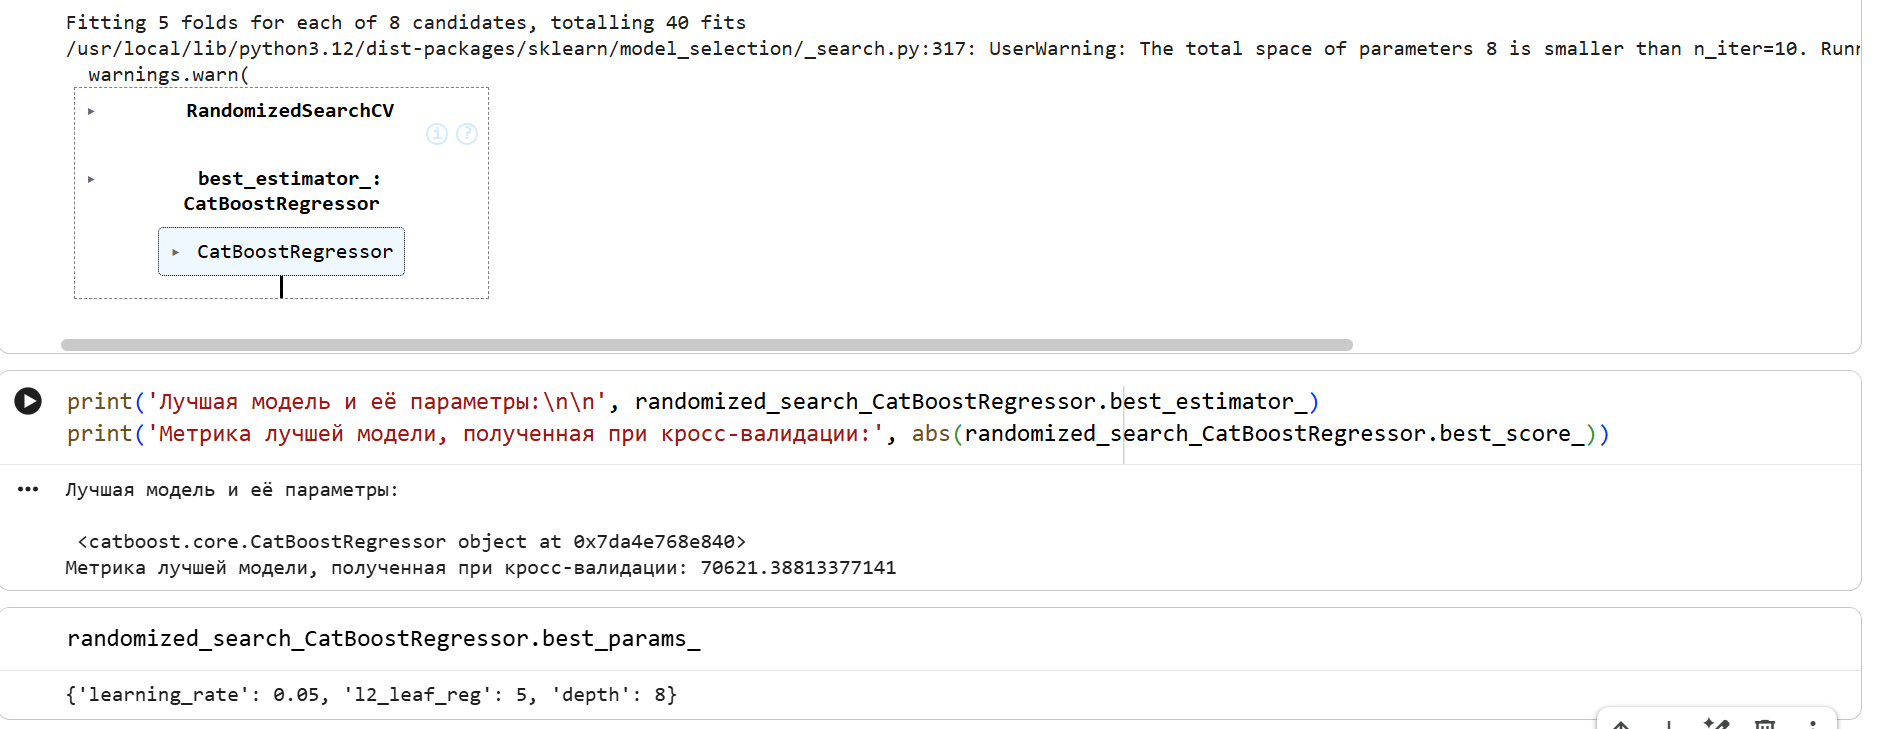

```
print('Лучшая модель и её параметры:\n\n', randomized_search_CatBoostRegressor.best_estimator_)
print('Метрика лучшей модели, полученная при кросс-валидации:', abs(randomized_search_CatBoostRegressor.best_score_))
randomized_search_CatBoostRegressor.best_params_
```

In [62]:
best_model = CatBoostRegressor(
    depth=8,
    learning_rate=0.05,
    l2_leaf_reg=5,
    loss_function='MAE',
    random_state=RANDOM_STATE,
    verbose=100,
    iterations=1000
)

In [63]:
best_model.fit(X_train, y_train, cat_features=cat_idx, sample_weight=w_train)

0:	learn: 129830.5041823	total: 410ms	remaining: 6m 49s
100:	learn: 75902.0446295	total: 23.4s	remaining: 3m 27s
200:	learn: 68866.6441907	total: 47.5s	remaining: 3m 8s
300:	learn: 64833.5628575	total: 1m 10s	remaining: 2m 43s
400:	learn: 62069.7071101	total: 1m 34s	remaining: 2m 21s
500:	learn: 60040.5107316	total: 1m 59s	remaining: 1m 59s
600:	learn: 58550.4812309	total: 2m 23s	remaining: 1m 35s
700:	learn: 57185.7959990	total: 2m 46s	remaining: 1m 11s
800:	learn: 56087.6996474	total: 3m 12s	remaining: 47.8s
900:	learn: 55139.3099653	total: 3m 36s	remaining: 23.8s
999:	learn: 54426.6205549	total: 3m 59s	remaining: 0us


In [64]:
# best_model = randomized_search_CatBoostRegressor.best_estimator_
y_pred_valid = best_model.predict(X_valid)
wmae_valid = np.sum(w_valid * np.abs(y_valid - y_pred_valid)) / np.sum(w_valid)
print(f"WMAE на валидации: {wmae_valid:.2f}")


WMAE на валидации: 71806.43


In [65]:
test_df = pd.read_csv('/content/drive/MyDrive/hackathon_income_test.csv', decimal=',', sep=';')

/tmp/ipython-input-4264504417.py:1: DtypeWarning: Columns (65) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv('/content/drive/MyDrive/hackathon_income_test.csv', decimal=',', sep=';')


In [66]:
X_test = test_df[X.columns.to_list()]
X_test.columns.to_list() == X_train.columns.to_list()

True

In [67]:
test_df.columns.to_list()

['id',
 'dt',
 'turn_cur_cr_avg_act_v2',
 'salary_6to12m_avg',
 'hdb_bki_total_max_limit',
 'dp_ils_paymentssum_avg_12m',
 'hdb_bki_total_cc_max_limit',
 'incomeValue',
 'gender',
 'avg_cur_cr_turn',
 'adminarea',
 'turn_cur_cr_avg_v2',
 'turn_cur_cr_max_v2',
 'hdb_bki_total_pil_max_limit',
 'age',
 'dp_ils_avg_salary_1y',
 'turn_cur_cr_sum_v2',
 'by_category__amount__sum__eoperation_type_name__ishodjaschij_bystryj_platezh_sbp',
 'turn_cur_db_sum_v2',
 'turn_cur_db_avg_act_v2',
 'dp_ils_avg_salary_2y',
 'curr_rur_amt_cm_avg',
 'turn_cur_db_avg_v2',
 'by_category__amount__sum__eoperation_type_name__vhodjaschij_bystryj_platezh_sbp',
 'dp_ils_paymentssum_avg_6m',
 'avg_cur_db_turn',
 'hdb_bki_active_cc_max_limit',
 'incomeValueCategory',
 'avg_by_category__amount__sum__cashflowcategory_name__vydacha_nalichnyh_v_bankomate',
 'avg_credit_turn_rur',
 'dp_ils_salary_ratio_1y3y',
 'by_category__amount__sum__eoperation_type_name__perevod_po_nomeru_telefona',
 'turn_cur_cr_7avg_avg_v2',
 'dp_ils

In [68]:
mask = features_description['признак'].isin(X_train.columns.to_list())

features_description_filtered = features_description[mask]
features_description_filtered.reset_index(drop=True)
features_description_filtered.to_csv('features_description_filtered.csv')

In [69]:
cat_cols_test = X_test.select_dtypes(include=['object']).columns
for col in cat_cols_test:
    X_test[col] = X_test[col].fillna('missing')

cat_idx_test = [X_test.columns.get_loc(c) for c in cat_cols_test]

/tmp/ipython-input-3537969737.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].fillna('missing')


In [70]:
y_test_pred = best_model.predict(X_test)

In [71]:
submission = pd.DataFrame({
    'id': test_df['id'],
    'target': y_test_pred
})

submission.head()

id        target
0   0  61226.133829
1   1  54092.316844
2   3  35944.968434
3   9  71777.164967
4  11  49875.532811

In [72]:
submission.to_csv('submission.csv', index=False)

In [73]:
client = X_test.sample(1)

In [74]:
best_model.predict(client)

array([85061.02075996])

In [75]:
explainer_client = shap.TreeExplainer(best_model, feature_perturbation="tree_path_dependent")
shap_client = explainer_client(client)

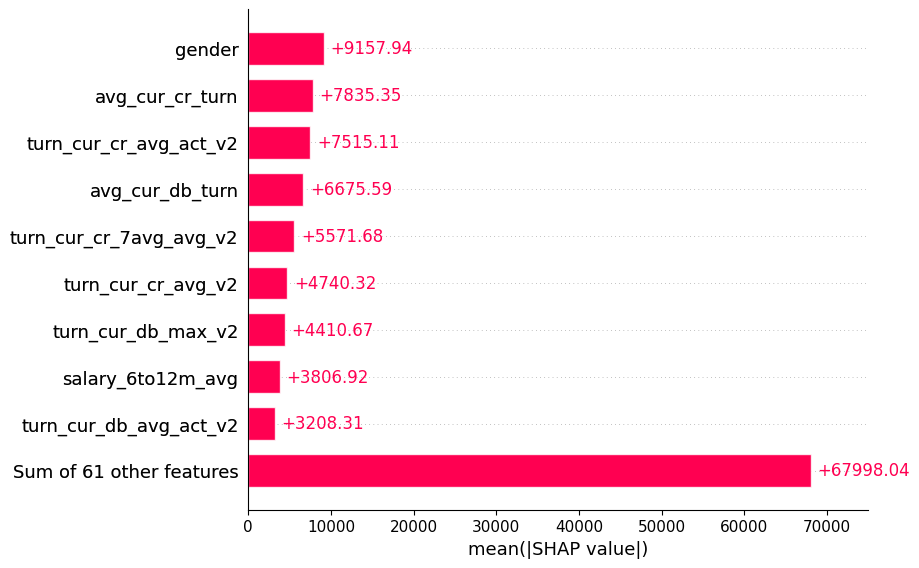

In [76]:
plt.figure(figsize=(8, 10))
shap.plots.bar(shap_client, show=False)
plt.show()

In [77]:
best_model.save_model("income_model.cbm")

In [78]:
import json

meta = {
    "feature_names": list(X_train.columns),
    "cat_feature_indices": cat_idx
}

with open("income_model_meta.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)